In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import json

# AoS2SoA

In [2]:
compilers = ["intel", "gcc", "clang"]
# compilers=["gcc"]


def get_layout(s):
    return s[s.find("<") - 3 : s.find("<")]


def get_container(s):
    if "Vec" in s:
        return "std::vector"
    elif "Arr" in s:
        return "std::array"
    else:
        return "Raw"


def get_container_inv(s):
    if "std::vector" in s:
        return "Vec"
    elif "std::array" in s:
        return "Arr"
    else:
        return "Raw"


def get_nmembers(row):
    lo = row["layout"]
    cntr = get_container_inv(row["container"])
    cntr_pos = row["name"].find(cntr)
    lo_pos = row["name"].rfind(lo) + len(lo)
    return int(row["name"][lo_pos:cntr_pos])


def get_type(s):
    return s.split("<")[2].split(",")[0].strip()


def get_operation(s):
    larrow = s.find("<")
    start = s.find("BM_") + 3
    return s[start : larrow - 3]

In [3]:
def read_file(results, cmplr, commit, autovec):
    with open(f"aos2soa/results_{cmplr}_{commit}_{autovec}", "r") as read_file:
        data = json.load(read_file)
        df = pd.DataFrame.from_dict(data["benchmarks"]).astype({"real_time": float})
        df["layout"] = df["name"].apply(get_layout)
        df["container"] = df["name"].apply(get_container)
        df["nmembers"] = df.apply(get_nmembers, axis=1)
        df["type"] = df["name"].apply(get_type)
        df["operation"] = df["name"].apply(get_operation)
        results[f"{cmplr}_{autovec}"] = df


commit = "6a16c4f"  # aos2soa onevec
# commit = "3888707"
# commit = "random"
results = {}
for cmplr in compilers:
    read_file(results, cmplr, commit, "novec")
    read_file(results, cmplr, commit, "vec")

results["gcc_vec"]

,name,family_index,per_family_instance_index,run_name,run_type,repetitions,repetition_index,threads,iterations,real_time,...,time_unit,instructions,size,aggregate_name,aggregate_unit,layout,container,nmembers,type,operation
0,"BM_MemoryBoundAoS<AoS2Vec<double, container_si...",0,0,"BM_MemoryBoundAoS<AoS2Vec<double, container_si...",iteration,10,0.0,1,61,11.060853,...,ms,7.250028e+07,10000000.0,NaN,NaN,AoS,std::vector,2,double,MemoryBound
1,"BM_MemoryBoundAoS<AoS2Vec<double, container_si...",0,0,"BM_MemoryBoundAoS<AoS2Vec<double, container_si...",iteration,10,1.0,1,61,10.954020,...,ms,7.250028e+07,10000000.0,NaN,NaN,AoS,std::vector,2,double,MemoryBound
2,"BM_MemoryBoundAoS<AoS2Vec<double, container_si...",0,0,"BM_MemoryBoundAoS<AoS2Vec<double, container_si...",iteration,10,2.0,1,61,10.967951,...,ms,7.250028e+07,10000000.0,NaN,NaN,AoS,std::vector,2,double,MemoryBound
3,"BM_MemoryBoundAoS<AoS2Vec<double, container_si...",0,0,"BM_MemoryBoundAoS<AoS2Vec<double, container_si...",iteration,10,3.0,1,61,11.117604,...,ms,7.250028e+07,10000000.0,NaN,NaN,AoS,std::vector,2,double,MemoryBound
4,"BM_MemoryBoundAoS<AoS2Vec<double, container_si...",0,0,"BM_MemoryBoundAoS<AoS2Vec<double, container_si...",iteration,10,4.0,1,61,11.260787,...,ms,7.250028e+07,10000000.0,NaN,NaN,AoS,std::vector,2,double,MemoryBound
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,"BM_ComputeBoundSoA<SoA20Vec<double, container_...",15,0,"BM_ComputeBoundSoA<SoA20Vec<double, container_...",iteration,10,9.0,1,12,63.192269,...,ms,2.275003e+08,10000000.0,NaN,NaN,SoA,std::vector,20,double,ComputeBound
220,"BM_ComputeBoundSoA<SoA20Vec<double, container_...",15,0,"BM_ComputeBoundSoA<SoA20Vec<double, container_...",aggregate,10,NaN,1,10,62.370200,...,ms,2.275003e+08,10000000.0,mean,time,SoA,std::vector,20,double,ComputeBound
221,"BM_ComputeBoundSoA<SoA20Vec<double, container_...",15,0,"BM_ComputeBoundSoA<SoA20Vec<double, container_...",aggregate,10,NaN,1,10,61.952046,...,ms,2.275003e+08,10000000.0,median,time,SoA,std::vector,20,double,ComputeBound
222,"BM_ComputeBoundSoA<SoA20Vec<double, container_...",15,0,"BM_ComputeBoundSoA<SoA20Vec<double, container_...",aggregate,10,NaN,1,10,0.975488,...,ms,0.000000e+00,0.0,stddev,time,SoA,std::vector,20,double,ComputeBound


In [4]:
df_mean = {}
df_median = {}
df_std = {}
df_runs = {}

for cmplr, df in results.items():
    df_mean[cmplr] = df[df["aggregate_name"] == "mean"]
    df_median[cmplr] = df[df["aggregate_name"] == "median"]
    df_std[cmplr] = df[df["aggregate_name"] == "stddev"]
    df_runs[cmplr] = df[df["aggregate_name"].isna()]

num_tests = df_runs["gcc_novec"]["family_index"].max() + 1
df_runs["gcc_novec"]

,name,family_index,per_family_instance_index,run_name,run_type,repetitions,repetition_index,threads,iterations,real_time,...,time_unit,instructions,size,aggregate_name,aggregate_unit,layout,container,nmembers,type,operation
0,"BM_MemoryBoundAoS<AoS2Vec<double, container_si...",0,0,"BM_MemoryBoundAoS<AoS2Vec<double, container_si...",iteration,10,0.0,1,54,11.932846,...,ms,1.575003e+08,10000000.0,NaN,NaN,AoS,std::vector,2,double,MemoryBound
1,"BM_MemoryBoundAoS<AoS2Vec<double, container_si...",0,0,"BM_MemoryBoundAoS<AoS2Vec<double, container_si...",iteration,10,1.0,1,54,11.967116,...,ms,1.575003e+08,10000000.0,NaN,NaN,AoS,std::vector,2,double,MemoryBound
2,"BM_MemoryBoundAoS<AoS2Vec<double, container_si...",0,0,"BM_MemoryBoundAoS<AoS2Vec<double, container_si...",iteration,10,2.0,1,54,12.075247,...,ms,1.575003e+08,10000000.0,NaN,NaN,AoS,std::vector,2,double,MemoryBound
3,"BM_MemoryBoundAoS<AoS2Vec<double, container_si...",0,0,"BM_MemoryBoundAoS<AoS2Vec<double, container_si...",iteration,10,3.0,1,54,12.004960,...,ms,1.575003e+08,10000000.0,NaN,NaN,AoS,std::vector,2,double,MemoryBound
4,"BM_MemoryBoundAoS<AoS2Vec<double, container_si...",0,0,"BM_MemoryBoundAoS<AoS2Vec<double, container_si...",iteration,10,4.0,1,54,11.965748,...,ms,1.575003e+08,10000000.0,NaN,NaN,AoS,std::vector,2,double,MemoryBound
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,"BM_ComputeBoundSoA<SoA20Vec<double, container_...",15,0,"BM_ComputeBoundSoA<SoA20Vec<double, container_...",iteration,10,5.0,1,3,279.779172,...,ms,1.300001e+09,10000000.0,NaN,NaN,SoA,std::vector,20,double,ComputeBound
216,"BM_ComputeBoundSoA<SoA20Vec<double, container_...",15,0,"BM_ComputeBoundSoA<SoA20Vec<double, container_...",iteration,10,6.0,1,3,276.209263,...,ms,1.300001e+09,10000000.0,NaN,NaN,SoA,std::vector,20,double,ComputeBound
217,"BM_ComputeBoundSoA<SoA20Vec<double, container_...",15,0,"BM_ComputeBoundSoA<SoA20Vec<double, container_...",iteration,10,7.0,1,3,283.131071,...,ms,1.300001e+09,10000000.0,NaN,NaN,SoA,std::vector,20,double,ComputeBound
218,"BM_ComputeBoundSoA<SoA20Vec<double, container_...",15,0,"BM_ComputeBoundSoA<SoA20Vec<double, container_...",iteration,10,8.0,1,3,284.510496,...,ms,1.300001e+09,10000000.0,NaN,NaN,SoA,std::vector,20,double,ComputeBound


## Bar Chart

/tmp/ipykernel_11637/4291977342.py:108: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  bp = sns.barplot(
/tmp/ipykernel_11637/4291977342.py:108: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  bp = sns.barplot(
/tmp/ipykernel_11637/4291977342.py:108: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  bp = sns.barplot(
/tmp/ipykernel_11637/4291977342.py:108: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  bp = sns.barplot(
/tmp/ipykernel_11637/4291977342.py:108: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  bp = sns.barplot(
/tmp/ipykernel_11637/4291977342.py:108: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  bp = sns.barplot(
/tmp/ipykernel_11637/4291977342.py:108: UserWarning: The palette list has mo

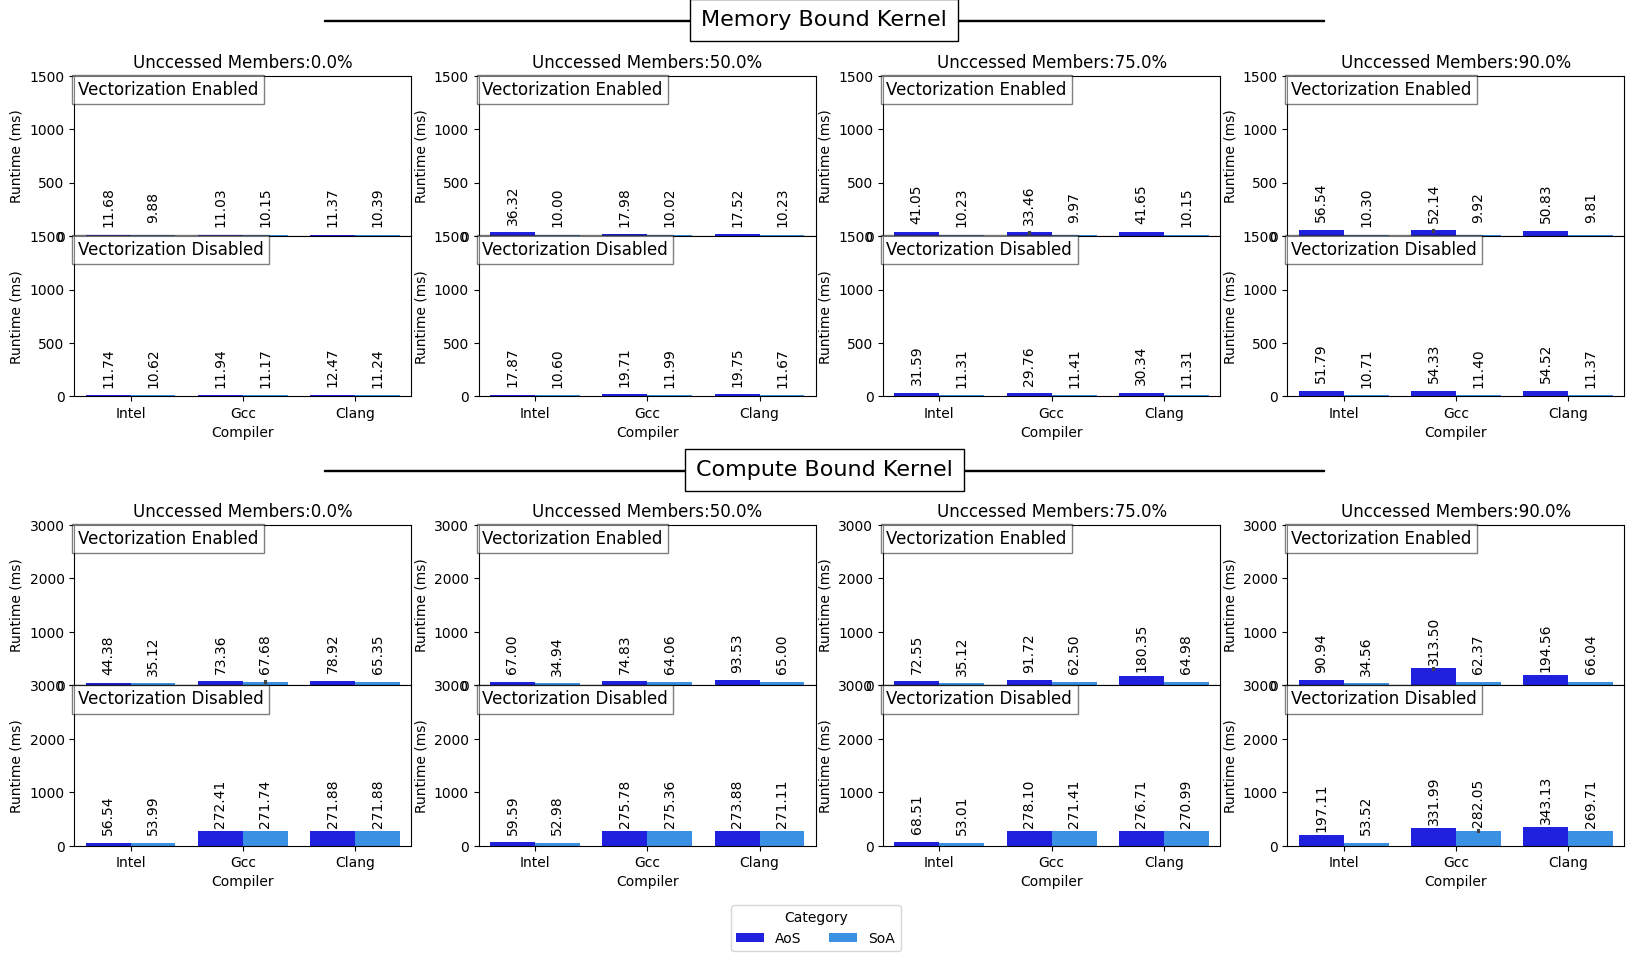

,name,family_index,per_family_instance_index,run_name,run_type,repetitions,repetition_index,threads,iterations,real_time,...,time_unit,instructions,size,aggregate_name,aggregate_unit,layout,container,nmembers,type,operation
210,"BM_ComputeBoundSoA<SoA20Vec<double, container_...",15,0,"BM_ComputeBoundSoA<SoA20Vec<double, container_...",iteration,10,0.0,1,3,267.595696,...,ms,1.310001e+09,10000000.0,NaN,NaN,SoA,std::vector,20,double,ComputeBound
211,"BM_ComputeBoundSoA<SoA20Vec<double, container_...",15,0,"BM_ComputeBoundSoA<SoA20Vec<double, container_...",iteration,10,1.0,1,3,275.329525,...,ms,1.310001e+09,10000000.0,NaN,NaN,SoA,std::vector,20,double,ComputeBound
212,"BM_ComputeBoundSoA<SoA20Vec<double, container_...",15,0,"BM_ComputeBoundSoA<SoA20Vec<double, container_...",iteration,10,2.0,1,3,270.048022,...,ms,1.310001e+09,10000000.0,NaN,NaN,SoA,std::vector,20,double,ComputeBound
213,"BM_ComputeBoundSoA<SoA20Vec<double, container_...",15,0,"BM_ComputeBoundSoA<SoA20Vec<double, container_...",iteration,10,3.0,1,3,265.785824,...,ms,1.310001e+09,10000000.0,NaN,NaN,SoA,std::vector,20,double,ComputeBound
214,"BM_ComputeBoundSoA<SoA20Vec<double, container_...",15,0,"BM_ComputeBoundSoA<SoA20Vec<double, container_...",iteration,10,4.0,1,3,267.206453,...,ms,1.310001e+09,10000000.0,NaN,NaN,SoA,std::vector,20,double,ComputeBound
215,"BM_ComputeBoundSoA<SoA20Vec<double, container_...",15,0,"BM_ComputeBoundSoA<SoA20Vec<double, container_...",iteration,10,5.0,1,3,267.132155,...,ms,1.310001e+09,10000000.0,NaN,NaN,SoA,std::vector,20,double,ComputeBound
216,"BM_ComputeBoundSoA<SoA20Vec<double, container_...",15,0,"BM_ComputeBoundSoA<SoA20Vec<double, container_...",iteration,10,6.0,1,3,269.346568,...,ms,1.310001e+09,10000000.0,NaN,NaN,SoA,std::vector,20,double,ComputeBound
217,"BM_ComputeBoundSoA<SoA20Vec<double, container_...",15,0,"BM_ComputeBoundSoA<SoA20Vec<double, container_...",iteration,10,7.0,1,3,266.775601,...,ms,1.310001e+09,10000000.0,NaN,NaN,SoA,std::vector,20,double,ComputeBound
218,"BM_ComputeBoundSoA<SoA20Vec<double, container_...",15,0,"BM_ComputeBoundSoA<SoA20Vec<double, container_...",iteration,10,8.0,1,3,274.348508,...,ms,1.310001e+09,10000000.0,NaN,NaN,SoA,std::vector,20,double,ComputeBound
219,"BM_ComputeBoundSoA<SoA20Vec<double, container_...",15,0,"BM_ComputeBoundSoA<SoA20Vec<double, container_...",iteration,10,9.0,1,3,273.538053,...,ms,1.310001e+09,10000000.0,NaN,NaN,SoA,std::vector,20,double,ComputeBound


In [5]:
import re

filter_base = list(df_runs.values())[0]
selected_size = filter_base["size"].mean()
selected_reps = filter_base["repetitions"].mean()
selected_unit = filter_base["time_unit"].values[0]


def plot_bars(selected_type, hmax_t=160, hmax_b=600, fig_name=None):
    fig = plt.figure(figsize=(20, 10))
    outer_grid = gridspec.GridSpec(2, 1, height_ratios=[1, 1], hspace=0.4)
    # Create the first nested GridSpec
    gs1 = gridspec.GridSpecFromSubplotSpec(
        2, 4, subplot_spec=outer_grid[0], wspace=0.2, hspace=0
    )
    # Create the second nested GridSpec
    gs2 = gridspec.GridSpecFromSubplotSpec(
        2, 4, subplot_spec=outer_grid[1], wspace=0.2, hspace=0
    )

    gs1_title = f'{filter_base["operation"].unique()[0]} Kernel'
    gs1_title = (
        re.sub(r"(?<!^)(?=[A-Z])", " ", filter_base["operation"].unique()[0])
        + " Kernel"
    )
    fig.text(
        0.5,
        0.935,
        " " * 2000,
        ha="center",
        va="center",
        fontsize=1,
        bbox=dict(facecolor="white", edgecolor="black", boxstyle="square,pad=0.01"),
    )
    fig.text(
        0.5,
        0.93,
        gs1_title,
        ha="center",
        fontsize=16,
        bbox=dict(facecolor="white", edgecolor="black", boxstyle="square,pad=0.5"),
    )

    gs2_title = (
        re.sub(r"(?<!^)(?=[A-Z])", " ", filter_base["operation"].unique()[1])
        + " Kernel"
    )
    fig.text(
        0.5,
        0.485,
        " " * 2000,
        ha="center",
        va="center",
        fontsize=1,
        bbox=dict(facecolor="white", edgecolor="black", boxstyle="square,pad=0.01"),
    )
    fig.text(
        0.5,
        0.48,
        gs2_title,
        ha="center",
        fontsize=16,
        bbox=dict(facecolor="white", edgecolor="black", boxstyle="square,pad=0.5"),
    )

    for oi, selected_operation in enumerate(filter_base["operation"].unique()):
        for vi, selected_vec in enumerate(["vec", "novec"]):
            for nmi, selected_nmembers in enumerate(filter_base["nmembers"].unique()):
                gs = gs1 if oi == 0 else gs2
                idx = oi * 4 + nmi
                ax = plt.Subplot(fig, gs[vi, nmi])
                if vi == 0:
                    ax.set_title(
                        # f"Data type:{selected_type}    Container size:{int(selected_size)}    Repetitions:{int(selected_reps)}    Accessed Members:{(2/selected_nmembers)*100}%"
                        f"Unccessed Members:{((selected_nmembers-2)/selected_nmembers)*100}%"
                    )
                data = {"Category": [], "Compiler": [], "Runtime": []}

                for cmplr in compilers:
                    df_cmplr = df_runs[f"{cmplr}_{selected_vec}"]
                    for lo in df_cmplr["layout"].unique():
                        for cntr in ["std::vector"]:
                            runs = df_cmplr[
                                (df_cmplr["operation"] == selected_operation)
                                & (df_cmplr["nmembers"] == selected_nmembers)
                                & (df_cmplr["type"] == selected_type)
                                & (df_cmplr["layout"] == lo)
                                & (df_cmplr["container"] == cntr)
                            ]
                            data["Category"].extend(
                                [l for c, l in zip(runs["container"], runs["layout"])]
                            )
                            data["Compiler"].extend(
                                np.repeat(cmplr.title(), selected_reps)
                            )
                            data["Runtime"].extend(runs["real_time"])

                df = pd.DataFrame(data)

                palette = [
                    "b",
                    "dodgerblue",
                    "skyblue",
                    "red",
                    "orangered",
                    "coral",
                ]
                bp = sns.barplot(
                    x="Compiler",
                    y="Runtime",
                    hue="Category",
                    palette=palette,
                    data=df,
                    ax=ax,
                    legend=(oi == 1 and vi == 1 and nmi == 3),
                )

                if oi == 1 and vi == 1 and nmi == 3:
                    sns.move_legend(
                        bp, loc="lower center", ncol=6, bbox_to_anchor=(-1.4, -0.7)
                    )

                for p in ax.patches:
                    if p.get_height() > 0:
                        ax.annotate(
                            f"{p.get_height():.2f}",
                            (p.get_x() + p.get_width() / 2.0, p.get_height()),
                            ha="center",
                            va="center",
                            xytext=(0, 20),
                            textcoords="offset points",
                            rotation=90,
                        )

                ax.text(
                    0.01,
                    0.97,
                    f"{'Vectorization Enabled' if selected_vec == 'vec' else 'Vectorization Disabled'}",
                    transform=ax.transAxes,
                    fontsize=12,
                    verticalalignment="top",
                    horizontalalignment="left",
                    bbox=dict(facecolor="white", alpha=0.5),
                )

                ax.set_ylim([0, hmax_t if oi == 0 else hmax_b])
                ax.set_ylabel(f"Runtime ({selected_unit})")
                fig.add_subplot(ax)

    if fig_name:
        plt.savefig(fig_name, format="pdf", bbox_inches="tight")
    plt.show()
    return runs


plot_bars("double", 1500, 3000, f"images/aos2soa_{commit}_doubles_vec_bars.pdf")

/tmp/ipykernel_11637/1176847888.py:111: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  bp = sns.barplot(
/tmp/ipykernel_11637/1176847888.py:111: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  bp = sns.barplot(
/tmp/ipykernel_11637/1176847888.py:111: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  bp = sns.barplot(
/tmp/ipykernel_11637/1176847888.py:111: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  bp = sns.barplot(
/tmp/ipykernel_11637/1176847888.py:111: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  bp = sns.barplot(
/tmp/ipykernel_11637/1176847888.py:111: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  bp = sns.barplot(
/tmp/ipykernel_11637/1176847888.py:111: UserWarning: The palette list has mo

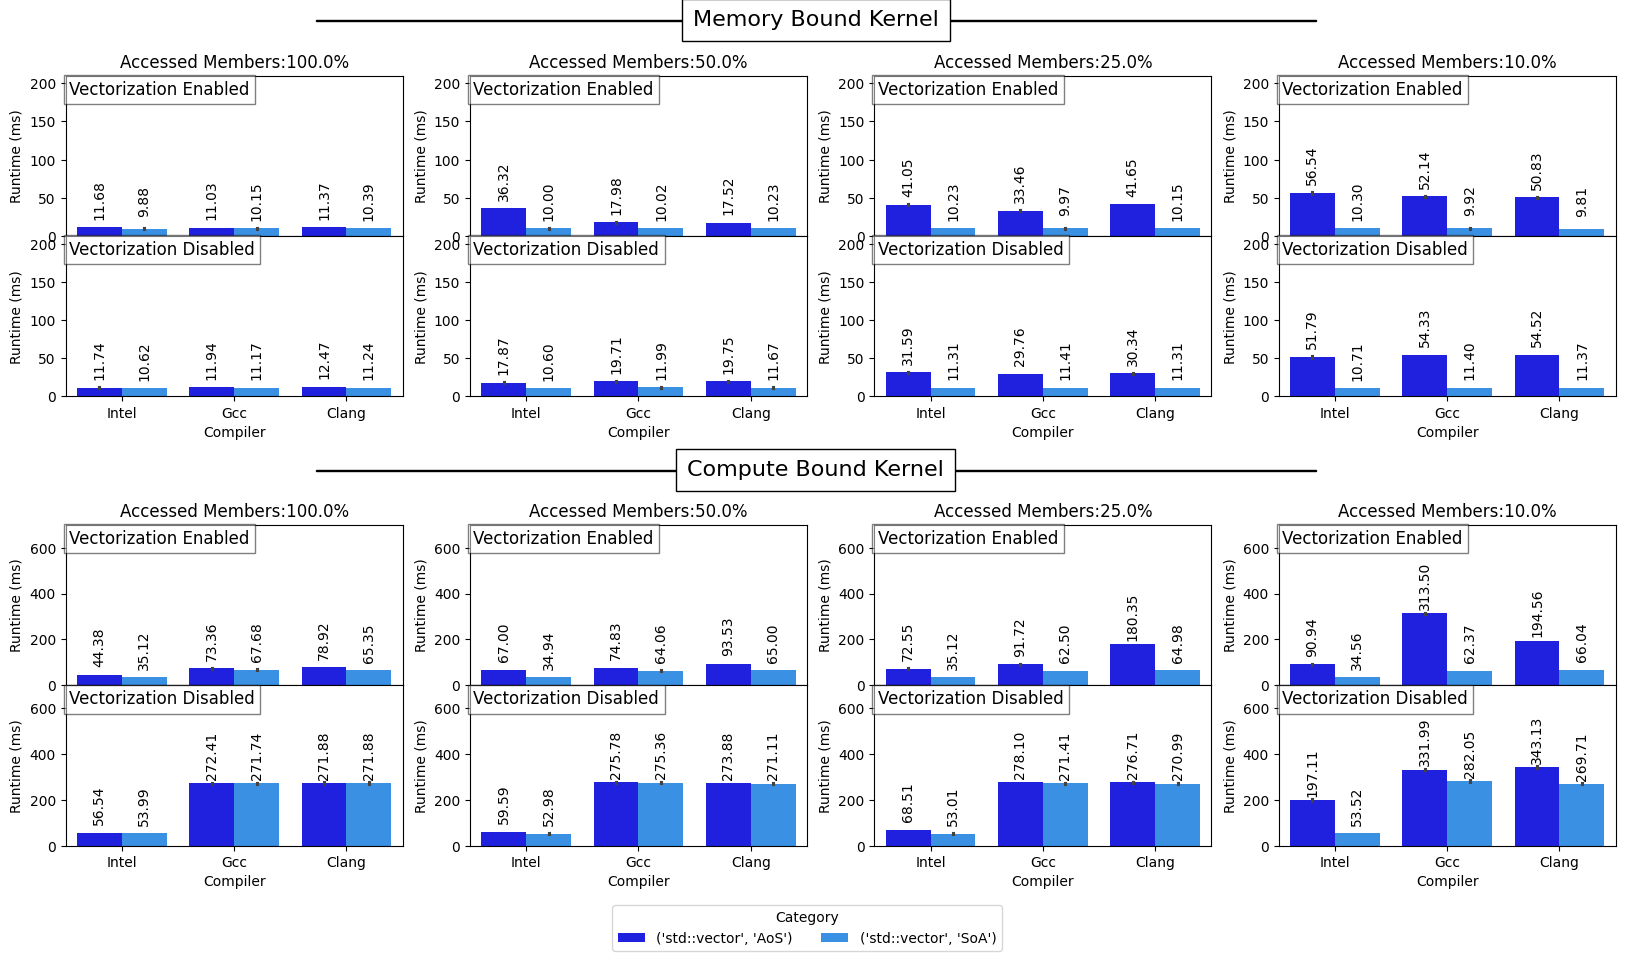

,name,family_index,per_family_instance_index,run_name,run_type,repetitions,repetition_index,threads,iterations,real_time,...,time_unit,instructions,size,aggregate_name,aggregate_unit,layout,container,nmembers,type,operation
210,"BM_ComputeBoundSoA<SoA20Vec<double, container_...",15,0,"BM_ComputeBoundSoA<SoA20Vec<double, container_...",iteration,10,0.0,1,3,267.595696,...,ms,1.310001e+09,10000000.0,NaN,NaN,SoA,std::vector,20,double,ComputeBound
211,"BM_ComputeBoundSoA<SoA20Vec<double, container_...",15,0,"BM_ComputeBoundSoA<SoA20Vec<double, container_...",iteration,10,1.0,1,3,275.329525,...,ms,1.310001e+09,10000000.0,NaN,NaN,SoA,std::vector,20,double,ComputeBound
212,"BM_ComputeBoundSoA<SoA20Vec<double, container_...",15,0,"BM_ComputeBoundSoA<SoA20Vec<double, container_...",iteration,10,2.0,1,3,270.048022,...,ms,1.310001e+09,10000000.0,NaN,NaN,SoA,std::vector,20,double,ComputeBound
213,"BM_ComputeBoundSoA<SoA20Vec<double, container_...",15,0,"BM_ComputeBoundSoA<SoA20Vec<double, container_...",iteration,10,3.0,1,3,265.785824,...,ms,1.310001e+09,10000000.0,NaN,NaN,SoA,std::vector,20,double,ComputeBound
214,"BM_ComputeBoundSoA<SoA20Vec<double, container_...",15,0,"BM_ComputeBoundSoA<SoA20Vec<double, container_...",iteration,10,4.0,1,3,267.206453,...,ms,1.310001e+09,10000000.0,NaN,NaN,SoA,std::vector,20,double,ComputeBound
215,"BM_ComputeBoundSoA<SoA20Vec<double, container_...",15,0,"BM_ComputeBoundSoA<SoA20Vec<double, container_...",iteration,10,5.0,1,3,267.132155,...,ms,1.310001e+09,10000000.0,NaN,NaN,SoA,std::vector,20,double,ComputeBound
216,"BM_ComputeBoundSoA<SoA20Vec<double, container_...",15,0,"BM_ComputeBoundSoA<SoA20Vec<double, container_...",iteration,10,6.0,1,3,269.346568,...,ms,1.310001e+09,10000000.0,NaN,NaN,SoA,std::vector,20,double,ComputeBound
217,"BM_ComputeBoundSoA<SoA20Vec<double, container_...",15,0,"BM_ComputeBoundSoA<SoA20Vec<double, container_...",iteration,10,7.0,1,3,266.775601,...,ms,1.310001e+09,10000000.0,NaN,NaN,SoA,std::vector,20,double,ComputeBound
218,"BM_ComputeBoundSoA<SoA20Vec<double, container_...",15,0,"BM_ComputeBoundSoA<SoA20Vec<double, container_...",iteration,10,8.0,1,3,274.348508,...,ms,1.310001e+09,10000000.0,NaN,NaN,SoA,std::vector,20,double,ComputeBound
219,"BM_ComputeBoundSoA<SoA20Vec<double, container_...",15,0,"BM_ComputeBoundSoA<SoA20Vec<double, container_...",iteration,10,9.0,1,3,273.538053,...,ms,1.310001e+09,10000000.0,NaN,NaN,SoA,std::vector,20,double,ComputeBound


In [6]:
import re

filter_base = list(df_runs.values())[0]
selected_size = filter_base["size"].mean()
selected_reps = filter_base["repetitions"].mean()
selected_unit = filter_base["time_unit"].values[0]


def plot_bars(selected_type, hmax_t=160, hmax_b=600, fig_name=None):
    fig = plt.figure(figsize=(20, 10))
    outer_grid = gridspec.GridSpec(2, 1, height_ratios=[1, 1], hspace=0.4)
    # Create the first nested GridSpec
    gs1 = gridspec.GridSpecFromSubplotSpec(
        2, 4, subplot_spec=outer_grid[0], wspace=0.2, hspace=0
    )
    # Create the second nested GridSpec
    gs2 = gridspec.GridSpecFromSubplotSpec(
        2, 4, subplot_spec=outer_grid[1], wspace=0.2, hspace=0
    )

    gs1_title = f'{filter_base["operation"].unique()[0]} Kernel'
    gs1_title = (
        re.sub(r"(?<!^)(?=[A-Z])", " ", filter_base["operation"].unique()[0])
        + " Kernel"
    )
    fig.text(
        0.5,
        0.935,
        " " * 2000,
        ha="center",
        va="center",
        fontsize=1,
        bbox=dict(facecolor="white", edgecolor="black", boxstyle="square,pad=0.01"),
    )
    fig.text(
        0.5,
        0.93,
        gs1_title,
        ha="center",
        fontsize=16,
        bbox=dict(facecolor="white", edgecolor="black", boxstyle="square,pad=0.5"),
    )

    gs2_title = (
        re.sub(r"(?<!^)(?=[A-Z])", " ", filter_base["operation"].unique()[1])
        + " Kernel"
    )
    fig.text(
        0.5,
        0.485,
        " " * 2000,
        ha="center",
        va="center",
        fontsize=1,
        bbox=dict(facecolor="white", edgecolor="black", boxstyle="square,pad=0.01"),
    )
    fig.text(
        0.5,
        0.48,
        gs2_title,
        ha="center",
        fontsize=16,
        bbox=dict(facecolor="white", edgecolor="black", boxstyle="square,pad=0.5"),
    )

    for oi, selected_operation in enumerate(filter_base["operation"].unique()):
        for vi, selected_vec in enumerate(["vec", "novec"]):
            for nmi, selected_nmembers in enumerate(filter_base["nmembers"].unique()):
                gs = gs1 if oi == 0 else gs2
                idx = oi * 4 + nmi
                ax = plt.Subplot(fig, gs[vi, nmi])
                if vi == 0:
                    ax.set_title(
                        # f"Data type:{selected_type}    Container size:{int(selected_size)}    Repetitions:{int(selected_reps)}    Accessed Members:{(2/selected_nmembers)*100}%"
                        f"Accessed Members:{(2/selected_nmembers)*100}%"
                    )
                data = {"Category": [], "Compiler": [], "Runtime": []}

                for cmplr in compilers:
                    df_cmplr = df_runs[f"{cmplr}_{selected_vec}"]
                    for lo in df_cmplr["layout"].unique():
                        for cntr in df_cmplr["container"].unique():
                            runs = df_cmplr[
                                (df_cmplr["operation"] == selected_operation)
                                & (df_cmplr["nmembers"] == selected_nmembers)
                                & (df_cmplr["type"] == selected_type)
                                & (df_cmplr["layout"] == lo)
                                & (df_cmplr["container"] == cntr)
                            ]
                            data["Category"].extend(
                                [
                                    (c, l)
                                    for c, l in zip(runs["container"], runs["layout"])
                                ]
                            )
                            data["Compiler"].extend(
                                np.repeat(cmplr.title(), selected_reps)
                            )
                            data["Runtime"].extend(runs["real_time"])

                df = pd.DataFrame(data)

                palette = [
                    "b",
                    "dodgerblue",
                    "skyblue",
                    "red",
                    "orangered",
                    "coral",
                ]
                bp = sns.barplot(
                    x="Compiler",
                    y="Runtime",
                    hue="Category",
                    palette=palette,
                    data=df,
                    ax=ax,
                    legend=(oi == 1 and vi == 1 and nmi == 3),
                )

                if oi == 1 and vi == 1 and nmi == 3:
                    sns.move_legend(
                        bp, loc="lower center", ncol=6, bbox_to_anchor=(-1.4, -0.7)
                    )

                for p in ax.patches:
                    if p.get_height() > 0:
                        ax.annotate(
                            f"{p.get_height():.2f}",
                            (p.get_x() + p.get_width() / 2.0, p.get_height()),
                            ha="center",
                            va="center",
                            xytext=(0, 20),
                            textcoords="offset points",
                            rotation=90,
                        )

                ax.text(
                    0.01,
                    0.97,
                    f"{'Vectorization Enabled' if selected_vec == 'vec' else 'Vectorization Disabled'}",
                    transform=ax.transAxes,
                    fontsize=12,
                    verticalalignment="top",
                    horizontalalignment="left",
                    bbox=dict(facecolor="white", alpha=0.5),
                )

                ax.set_ylim([0, hmax_t if oi == 0 else hmax_b])
                ax.set_ylabel(f"Runtime ({selected_unit})")
                fig.add_subplot(ax)

    if fig_name:
        plt.savefig(fig_name, format="pdf", bbox_inches="tight")
    plt.show()
    return runs


plot_bars("double", 210, 700, f"images/aos2soa_{commit}_doubles_bars.pdf")

In [7]:
# plot_bars("float", 110, 640, f"images/aos2soa_{commit}_floats_bars.pdf");

## Line Chart

In [8]:
markers = [
    "o",
    "s",
    "D",
    "^",
    "v",
    "P",
    "X",
    "p",
    "h",
    "d",
    "H",
    "8",
    "1",
    "2",
    "3",
    "4",
    "8",
    "s",
    "p",
    "P",
    "*",
    "x",
    "X",
    "D",
    "d",
    "h",
    "H",
    "v",
    "^",
    "<",
    ">",
]
linestyles = ["-", "--", "-.", ":"]
colors = [
    "b",
    "dodgerblue",
    "green",
    "darkseagreen",
    "orangered",
    "coral",
]

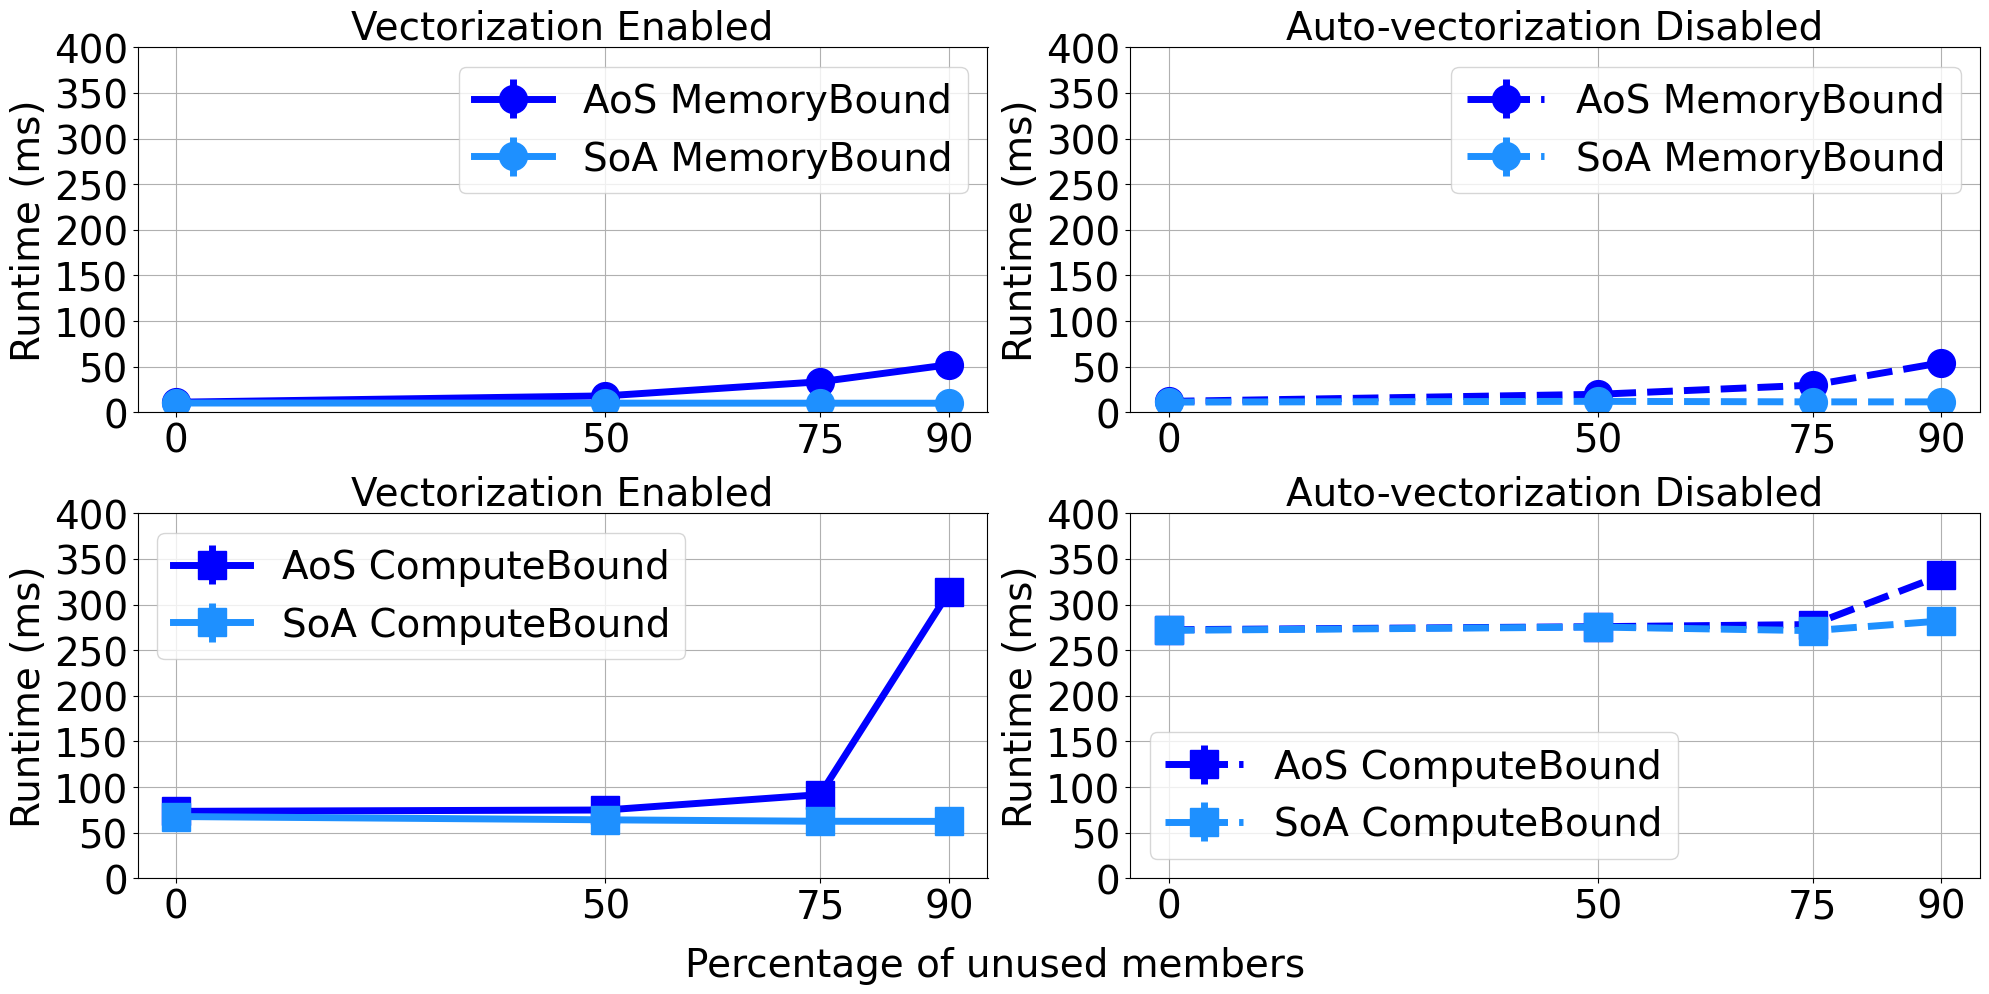

In [9]:
import itertools

selected_type = "double"
selected_size = list(df_mean.values())[0]["size"].mean()
selected_reps = list(df_mean.values())[0]["repetitions"].mean()
selected_unit = list(df_mean.values())[0]["time_unit"].values[0]
selected_cmplr = "gcc"
selected_container = "std::vector"


fig = plt.figure(figsize=(20, 10))
# plt.title(
#     f"Data type:{selected_type}    Container size:{int(selected_size)}    Repetitions:{int(selected_reps)}"
# )

colors = ["b", "dodgerblue"]

for vi, selected_vec in enumerate(["vec", "novec"]):
    avg = df_mean[f"{selected_cmplr}_{selected_vec}"].copy()
    std = df_std[f"{selected_cmplr}_{selected_vec}"].copy()
    nmembers_list = avg["nmembers"].unique()
    for oi, selected_op in enumerate(avg["operation"].unique()):
        ax = plt.subplot(2, 2, oi * 2 + vi + 1)
        for li, selected_lo in enumerate(avg["layout"].unique()):
            avg_filtered = avg[
                (avg["type"] == selected_type)
                & (avg["container"] == selected_container)
                & (avg["layout"] == selected_lo)
                & (avg["operation"] == selected_op)
            ]
            std_filtered = std[
                (std["type"] == selected_type)
                & (std["container"] == selected_container)
                & (std["layout"] == selected_lo)
                & (std["operation"] == selected_op)
            ]

            x = (nmembers_list - 2) / nmembers_list * 100
            plt.errorbar(
                x,
                avg_filtered["real_time"],
                yerr=std_filtered["real_time"],
                label=f"{selected_lo} {selected_op}",
                marker=markers[oi],
                color=colors[li],
                ls=linestyles[vi],
                lw=5,
                ms=20,
            )
            plt.title(
                f"{'Vectorization Enabled' if selected_vec == 'vec' else 'Auto-vectorization Disabled'}",
                fontsize=28,
            )

        plt.xticks(x, fontsize=28)
        plt.yticks(fontsize=28)

        plt.ylabel(f"Runtime ({selected_unit})", fontsize=28)
        plt.ylim([0, 400])
        plt.xticks(x)
        plt.legend(fontsize=28)

        plt.grid()

fig.supxlabel("Percentage of unused members", fontsize=28)

plt.tight_layout()
plt.savefig(
    f"images/aos2soa_{selected_type}_{commit}.pdf", format="pdf", bbox_inches="tight"
)
plt.show()

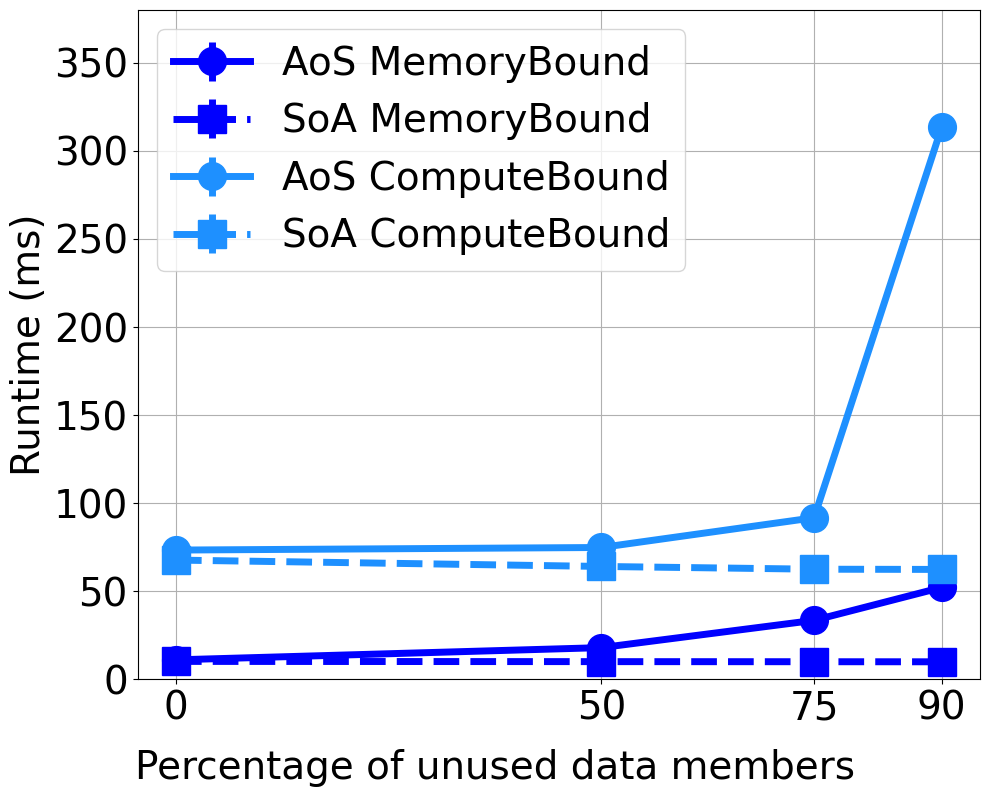

In [10]:
import itertools

selected_type = "double"
selected_size = list(df_mean.values())[0]["size"].mean()
selected_reps = list(df_mean.values())[0]["repetitions"].mean()
selected_unit = list(df_mean.values())[0]["time_unit"].values[0]
selected_cmplr = "gcc"
selected_container = "std::vector"


fig = plt.figure(figsize=(10, 8))
# plt.title(
#     f"Data type:{selected_type}    Container size:{int(selected_size)}    Repetitions:{int(selected_reps)}"
# )

colors = [
    "b",
    "dodgerblue",
    # "green",
]

for vi, selected_vec in enumerate(["vec"]):
    avg = df_mean[f"{selected_cmplr}_{selected_vec}"].copy()
    std = df_std[f"{selected_cmplr}_{selected_vec}"].copy()
    nmembers_list = avg["nmembers"].unique()
    for oi, selected_op in enumerate(avg["operation"].unique()):
        # ax = plt.subplot(2, 1, oi * 1 + vi + 1)
        for li, selected_lo in enumerate(avg["layout"].unique()):
            avg_filtered = avg[
                (avg["type"] == selected_type)
                & (avg["container"] == selected_container)
                & (avg["layout"] == selected_lo)
                & (avg["operation"] == selected_op)
            ]
            std_filtered = std[
                (std["type"] == selected_type)
                & (std["container"] == selected_container)
                & (std["layout"] == selected_lo)
                & (std["operation"] == selected_op)
            ]

            x = (nmembers_list - 2) / nmembers_list * 100
            plt.errorbar(
                x,
                avg_filtered["real_time"],
                yerr=std_filtered["real_time"],
                label=f"{selected_lo} {selected_op}",
                marker=markers[li],
                color=colors[oi],
                ls=linestyles[li],
                lw=5,
                ms=20,
            )

        plt.xticks(x, fontsize=28)
        plt.yticks(fontsize=28)

        plt.ylabel(f"Runtime ({selected_unit})", fontsize=28)
        plt.ylim([0, 380])
        plt.xticks(x)
        plt.legend(fontsize=28, loc="upper left")

plt.grid()

fig.supxlabel("Percentage of unused data members", fontsize=28)

plt.tight_layout()
plt.savefig(
    f"images/aos2soa_vec_{selected_type}_{commit}.pdf",
    format="pdf",
    bbox_inches="tight",
)
plt.show()

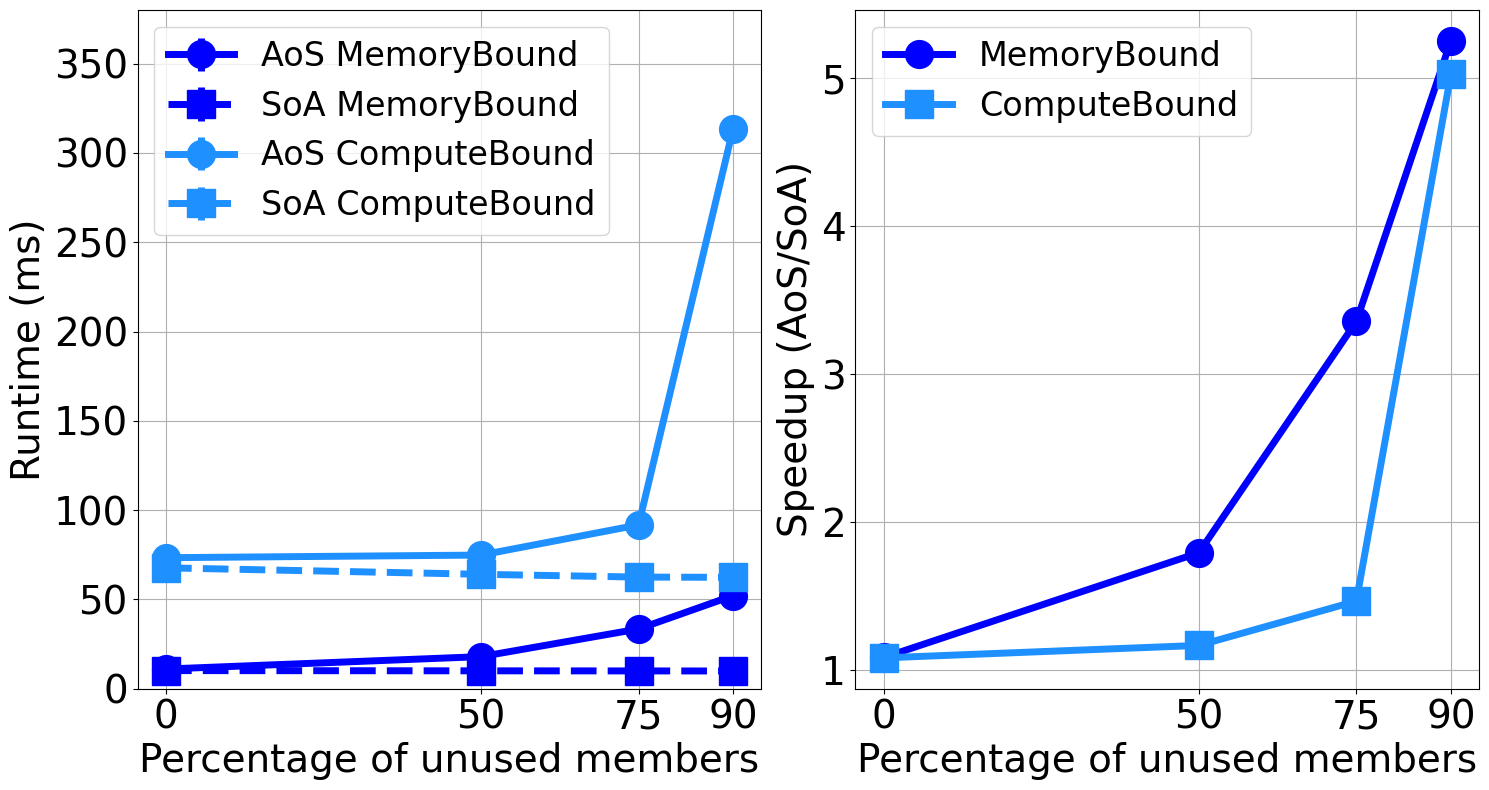

In [11]:
import itertools

selected_type = "double"
selected_size = list(df_mean.values())[0]["size"].mean()
selected_reps = list(df_mean.values())[0]["repetitions"].mean()
selected_unit = list(df_mean.values())[0]["time_unit"].values[0]
selected_cmplr = "gcc"
selected_container = "std::vector"


fig = plt.figure(figsize=(15, 8))
# plt.title(
#     f"Data type:{selected_type}    Container size:{int(selected_size)}    Repetitions:{int(selected_reps)}"
# )

colors = [
    "b",
    "dodgerblue",
    # "green",
]

ax = plt.subplot(1, 2, 1)
for vi, selected_vec in enumerate(["vec"]):
    avg = df_mean[f"{selected_cmplr}_{selected_vec}"].copy()
    std = df_std[f"{selected_cmplr}_{selected_vec}"].copy()
    nmembers_list = avg["nmembers"].unique()
    for oi, selected_op in enumerate(avg["operation"].unique()):
        for li, selected_lo in enumerate(avg["layout"].unique()):
            avg_filtered = avg[
                (avg["type"] == selected_type)
                & (avg["container"] == selected_container)
                & (avg["layout"] == selected_lo)
                & (avg["operation"] == selected_op)
            ]
            std_filtered = std[
                (std["type"] == selected_type)
                & (std["container"] == selected_container)
                & (std["layout"] == selected_lo)
                & (std["operation"] == selected_op)
            ]

            x = (nmembers_list - 2) / nmembers_list * 100
            plt.errorbar(
                x,
                avg_filtered["real_time"],
                yerr=std_filtered["real_time"],
                label=f"{selected_lo} {selected_op}",
                marker=markers[li],
                color=colors[oi],
                ls=linestyles[li],
                lw=5,
                ms=20,
            )

plt.xticks(x, fontsize=28)
plt.yticks(fontsize=28)

plt.ylabel(f"Runtime ({selected_unit})", fontsize=28)
plt.ylim([0, 380])
plt.xticks(x)
plt.legend(fontsize=24, loc="upper left")
plt.xlabel("Percentage of unused members", fontsize=28)
plt.grid()

ax = plt.subplot(1, 2, 2)
nmembers_list = avg["nmembers"].unique()
for oi, selected_op in enumerate(avg["operation"].unique()):
    avg_filtered = avg[
        (avg["type"] == selected_type)
        & (avg["container"] == selected_container)
        & (avg["operation"] == selected_op)
    ]
    std_filtered = std[
        (std["type"] == selected_type)
        & (std["container"] == selected_container)
        & (std["operation"] == selected_op)
    ]
    avg_aos = avg_filtered[avg_filtered["layout"] == "AoS"]
    std_aos = std_filtered[std_filtered["layout"] == "AoS"]
    avg_soa = avg_filtered[avg_filtered["layout"] == "SoA"]
    std_soa = std_filtered[std_filtered["layout"] == "SoA"]

    x = (nmembers_list - 2) / nmembers_list * 100
    plt.errorbar(
        x,
        avg_aos["real_time"].values / avg_soa["real_time"],
        # yerr=std_aos,
        label=f"{selected_op}",
        marker=markers[oi],
        color=colors[oi],
        lw=5,
        ms=20,
    )

plt.xticks(x, fontsize=28)
plt.yticks(fontsize=28)
plt.xlabel("Percentage of unused members", fontsize=28)
plt.ylabel(f"Speedup (AoS/SoA)", fontsize=28)
plt.grid()
plt.legend(fontsize=24, loc="upper left")

# fig.supxlabel("Percentage of unused data members", fontsize=28)

plt.tight_layout()
plt.savefig(
    f"images/aos2soa_vec_{selected_type}_{commit}_runspeedup.pdf",
    format="pdf",
    bbox_inches="tight",
)
plt.show()

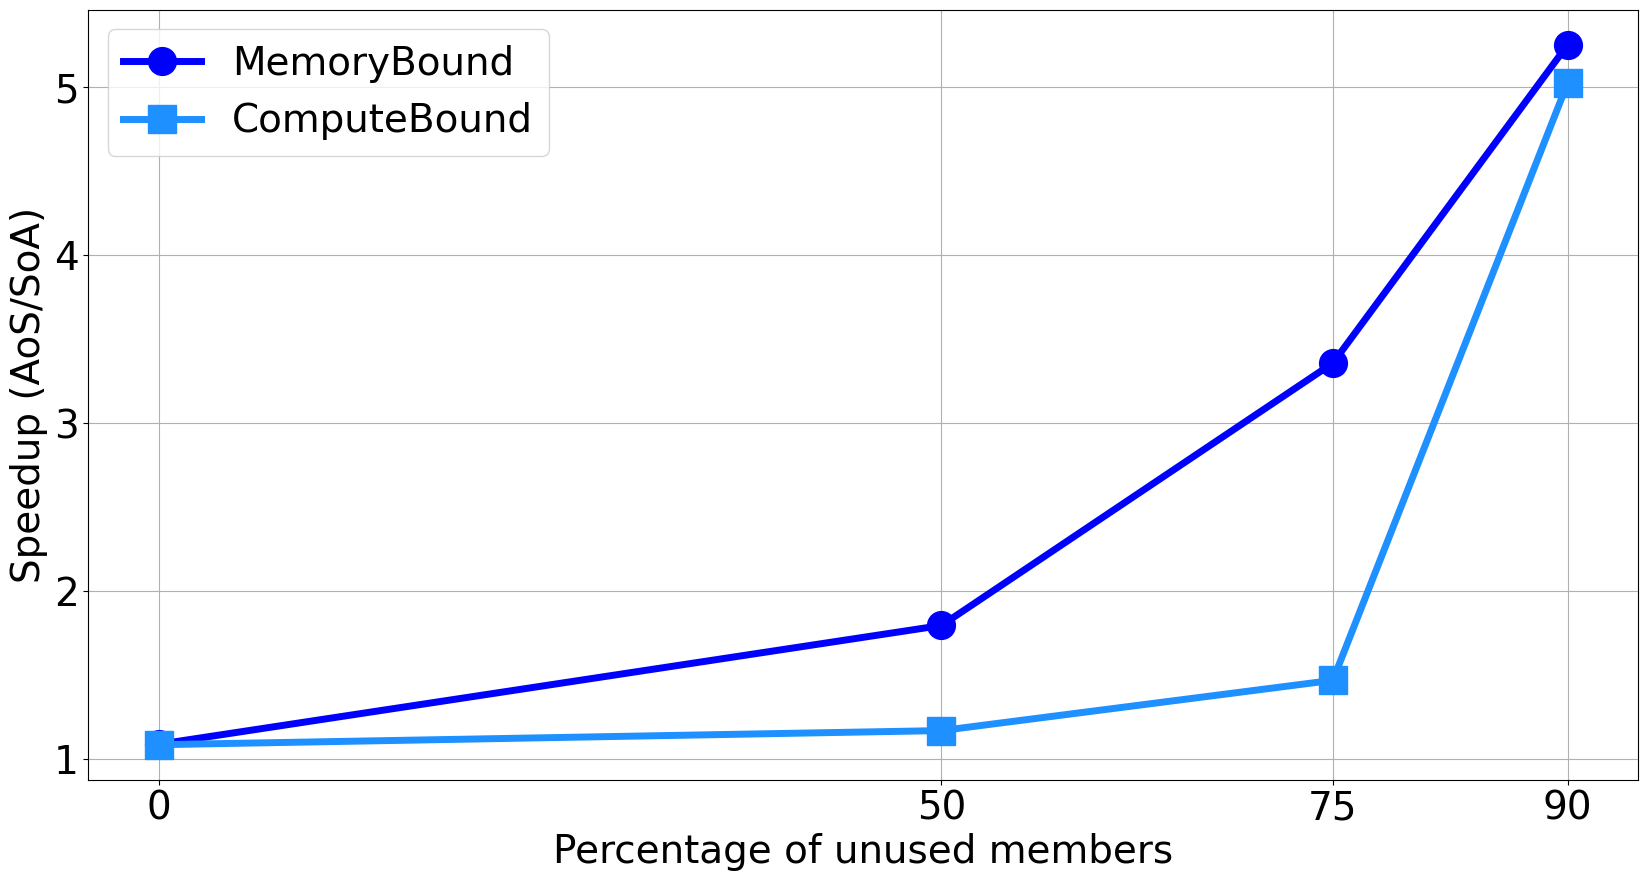

In [12]:
import itertools

selected_type = "double"
selected_size = list(df_mean.values())[0]["size"].mean()
selected_reps = list(df_mean.values())[0]["repetitions"].mean()
selected_unit = list(df_mean.values())[0]["time_unit"].values[0]
selected_cmplr = "gcc"
selected_container = "std::vector"
selected_vec = "vec"

plt.figure(figsize=(20, 10))
ax = plt.subplot(111)
# plt.title(
#     f"Data type:{selected_type}    Container size:{int(selected_size)}    Repetitions:{int(selected_reps)}"
# )

avg = df_mean[f"{selected_cmplr}_{selected_vec}"].copy()
std = df_std[f"{selected_cmplr}_{selected_vec}"].copy()
markers = ["o", "s", "D", "^", "v", "P", "X", "p", "h", "d", "H", "8", "1", "2", "3", "4", "8", "s", "p", "P", "*", "x", "X", "D", "d", "h", "H", "v", "^", "<", ">"]
linestyles = ["-", "--", "-.", ":"]

def map_vec(s):
    if s == "vec":
        return "SIMD"
    else:
        return "No SIMD"


nmembers_list = avg["nmembers"].unique()
for oi, selected_op in enumerate(avg["operation"].unique()):
    avg_filtered = avg[
        (avg["type"] == selected_type)
        & (avg["container"] == selected_container)
        & (avg["operation"] == selected_op)
    ]
    std_filtered = std[
        (std["type"] == selected_type)
        & (std["container"] == selected_container)
        & (std["operation"] == selected_op)
    ]
    avg_aos = avg_filtered[avg_filtered["layout"] == "AoS"]
    std_aos = std_filtered[std_filtered["layout"] == "AoS"]
    avg_soa = avg_filtered[avg_filtered["layout"] == "SoA"]
    std_soa = std_filtered[std_filtered["layout"] == "SoA"]

    x = (nmembers_list - 2) / nmembers_list * 100
    plt.errorbar(
        x,
        avg_aos["real_time"].values / avg_soa["real_time"],
        # yerr=std_aos,
        label=f"{selected_op}",
        marker=markers[oi],
        color=colors[oi],
        lw=5,
        ms=20,
    )

    plt.xticks(x, fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Percentage of unused members", fontsize=28)
    plt.ylabel(f"Speedup (AoS/SoA)", fontsize=28)

# plt.ylim([0, 40])
plt.ylabel(f"Speedup (AoS/SoA)")
plt.legend(loc="upper left", fontsize=28)
plt.grid()

# plt.xlim([0, 110])
plt.xticks(x)
plt.xlabel("Percentage of unused members")
plt.savefig(
    f"images/aos2soa_{selected_type}_{commit}_speedup.pdf",
    format="pdf",
    bbox_inches="tight",
)
plt.show()

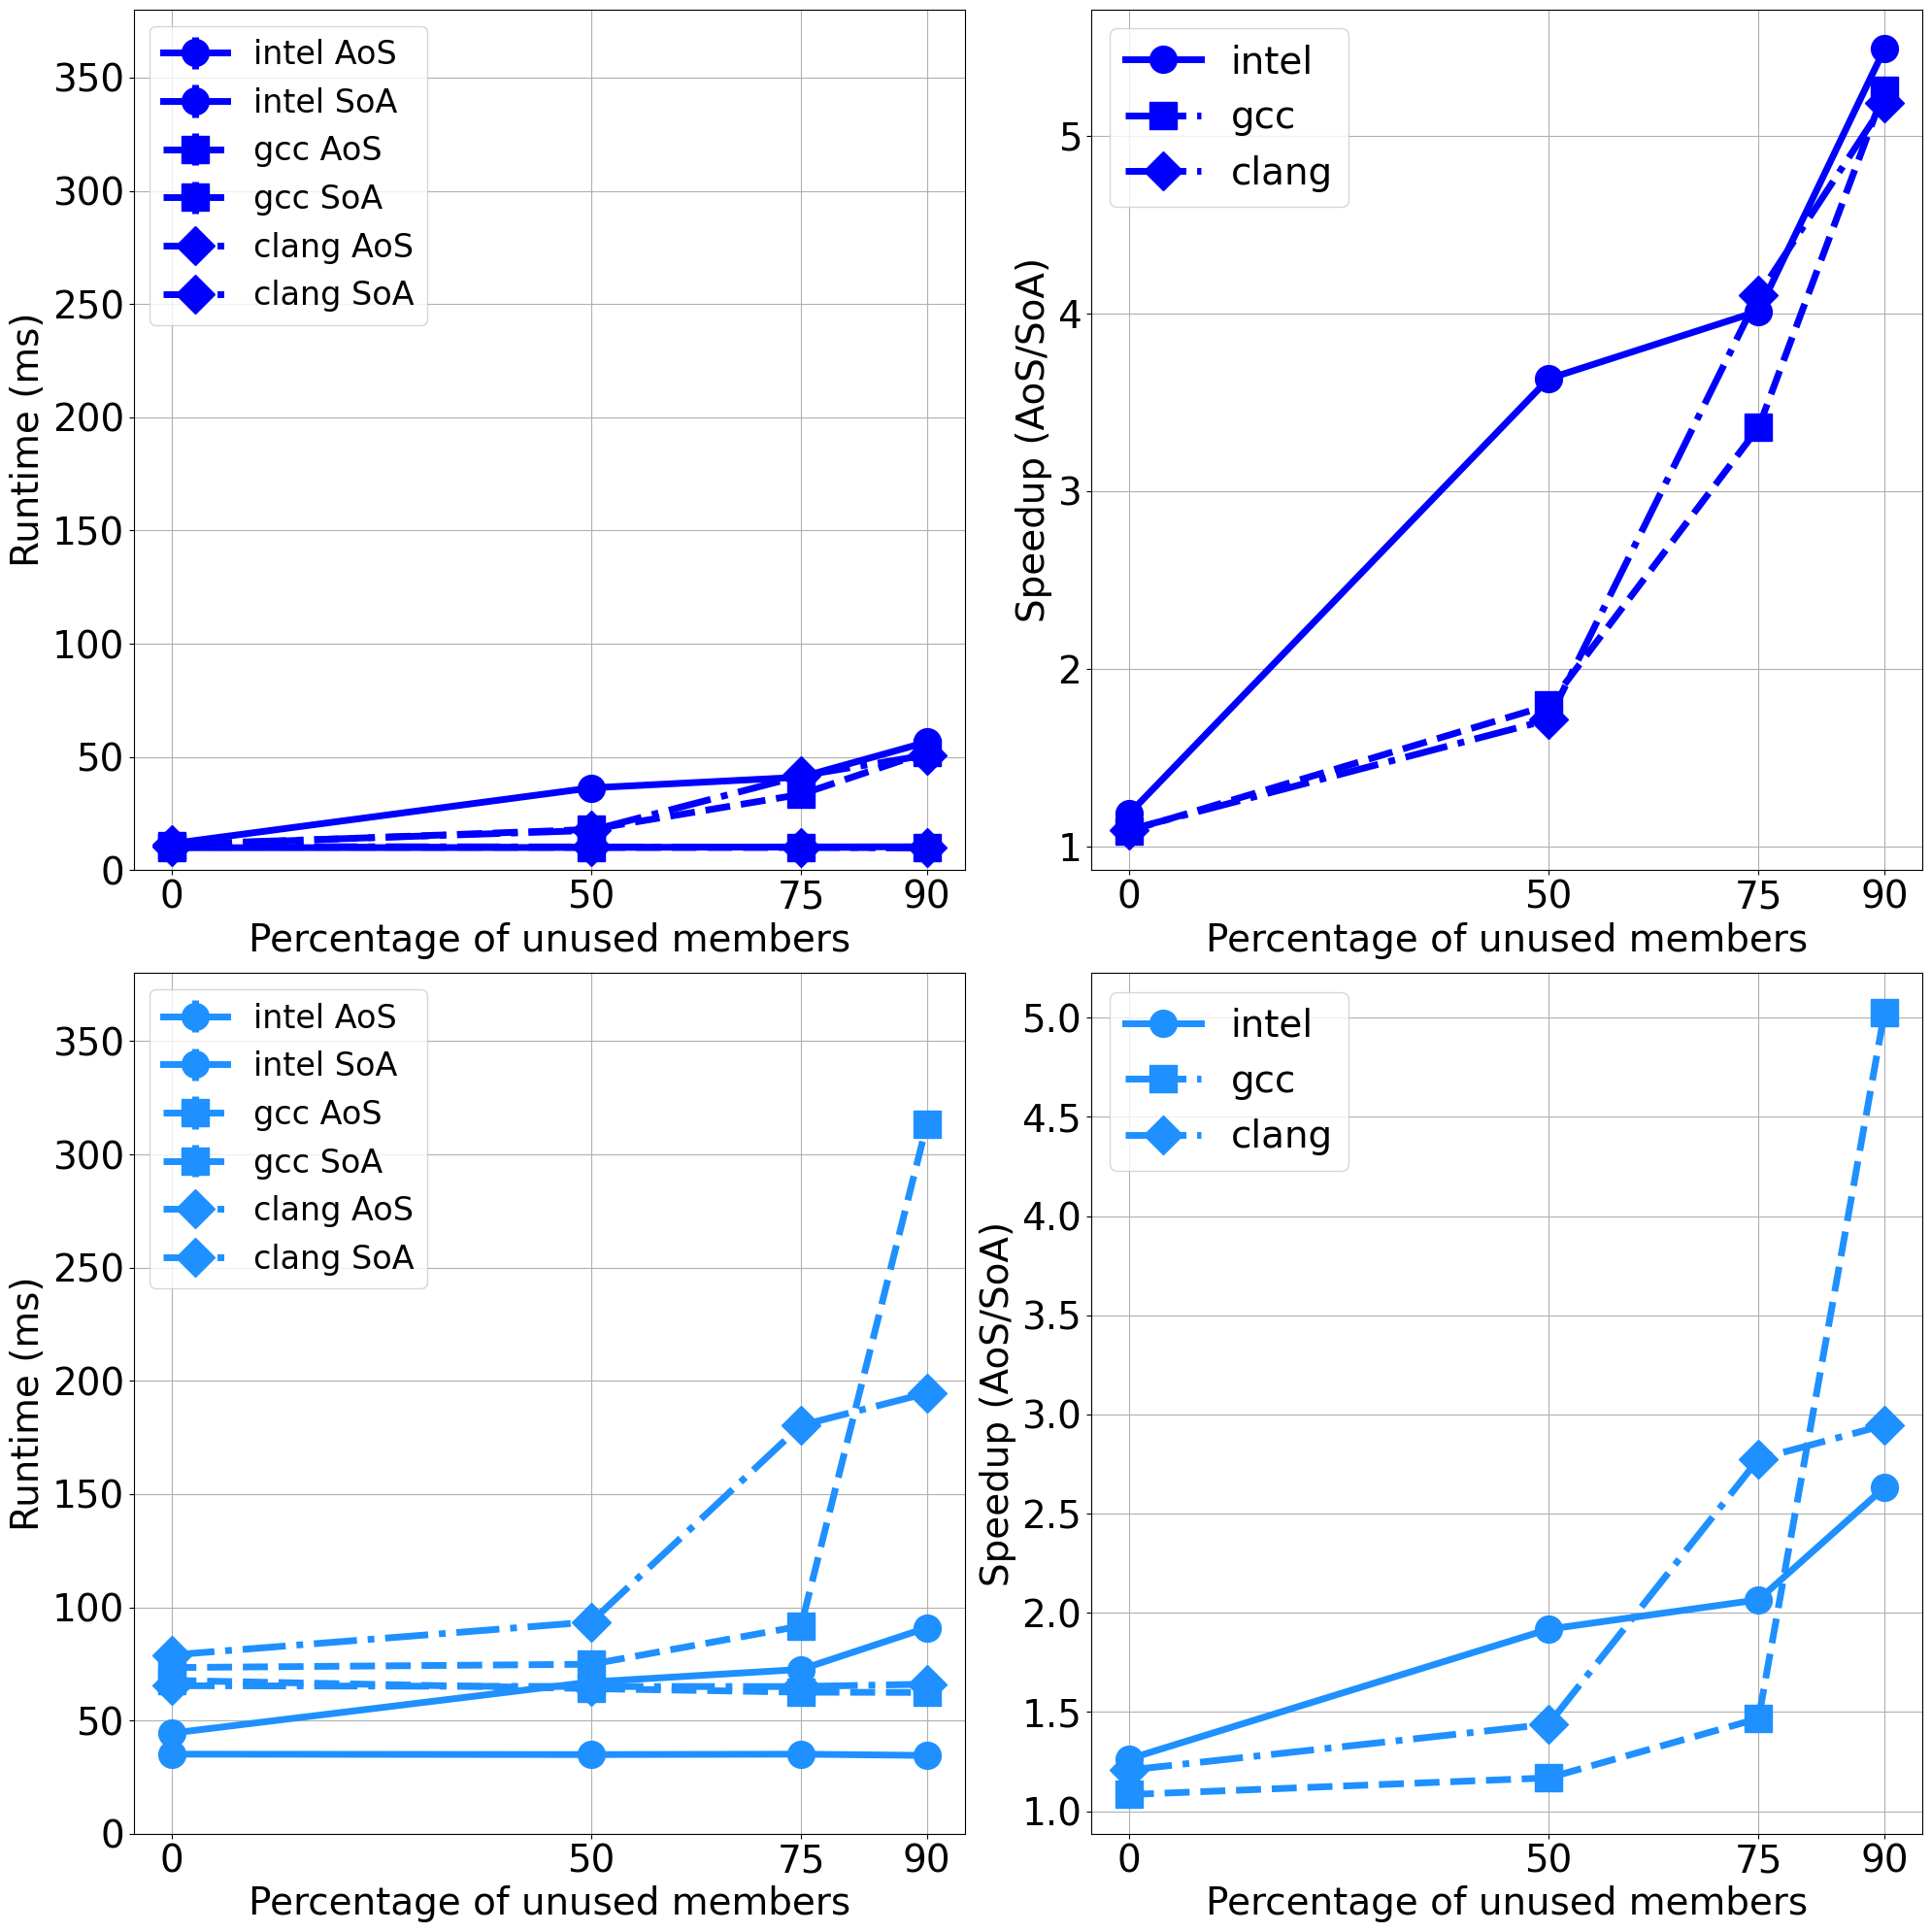

In [13]:
import itertools

selected_type = "double"
selected_size = list(df_mean.values())[0]["size"].mean()
selected_reps = list(df_mean.values())[0]["repetitions"].mean()
selected_unit = list(df_mean.values())[0]["time_unit"].values[0]
selected_container = "std::vector"
selected_vec = "vec"

plt.figure(figsize=(20, 20))

def map_vec(s):
    if s == "vec":
        return "SIMD"
    else:
        return "No SIMD"
    
for ci, selected_cmplr in enumerate(compilers):
    avg = df_mean[f"{selected_cmplr}_{selected_vec}"].copy()
    std = df_std[f"{selected_cmplr}_{selected_vec}"].copy()
    nmembers_list = avg["nmembers"].unique()
    for oi, selected_op in enumerate(avg["operation"].unique()):
        ax = plt.subplot(2, 2, oi *2 + 1)
        for li, selected_lo in enumerate(avg["layout"].unique()):
            avg_filtered = avg[
                (avg["type"] == selected_type)
                & (avg["container"] == selected_container)
                & (avg["layout"] == selected_lo)
                & (avg["operation"] == selected_op)
            ]
            std_filtered = std[
                (std["type"] == selected_type)
                & (std["container"] == selected_container)
                & (std["layout"] == selected_lo)
                & (std["operation"] == selected_op)
            ]

            x = (nmembers_list - 2) / nmembers_list * 100
            plt.errorbar(
                x,
                avg_filtered["real_time"],
                yerr=std_filtered["real_time"],
                label=f"{selected_cmplr} {selected_lo}",
                marker=markers[ci],
                color=colors[oi],
                ls=linestyles[ci],
                lw=5,
                ms=20,
            )
        plt.xticks(x, fontsize=28)
        plt.yticks(fontsize=28)

        plt.ylabel(f"Runtime ({selected_unit})", fontsize=28)
        plt.ylim([0, 380])
        plt.xticks(x)
        plt.legend(fontsize=24, loc="upper left")
        plt.xlabel("Percentage of unused members", fontsize=28)
        plt.grid()
 
for ci, selected_cmplr in enumerate(compilers):
    avg = df_mean[f"{selected_cmplr}_{selected_vec}"].copy()
    std = df_std[f"{selected_cmplr}_{selected_vec}"].copy()
    nmembers_list = avg["nmembers"].unique()
    for oi, selected_op in enumerate(avg["operation"].unique()):
        ax = plt.subplot(2,2, oi * 2 + 2)
        avg_filtered = avg[
            (avg["type"] == selected_type)
            & (avg["container"] == selected_container)
            & (avg["operation"] == selected_op)
        ]
        std_filtered = std[
            (std["type"] == selected_type)
            & (std["container"] == selected_container)
            & (std["operation"] == selected_op)
        ]
        avg_aos = avg_filtered[avg_filtered["layout"] == "AoS"]
        std_aos = std_filtered[std_filtered["layout"] == "AoS"]
        avg_soa = avg_filtered[avg_filtered["layout"] == "SoA"]
        std_soa = std_filtered[std_filtered["layout"] == "SoA"]

        x = (nmembers_list - 2) / nmembers_list * 100
        plt.errorbar(
            x,
            avg_aos["real_time"].values / avg_soa["real_time"],
            # yerr=std_aos,
            label=f"{selected_cmplr}",
            marker=markers[ci],
            color=colors[oi],
            ls=linestyles[ci],
            lw=5,
            ms=20,
        )

        plt.xticks(x, fontsize=28)
        plt.yticks(fontsize=28)
        plt.xlabel("Percentage of unused members", fontsize=28)
        plt.ylabel(f"Speedup (AoS/SoA)", fontsize=28)
        plt.legend(loc="upper left", fontsize=28)
        
        plt.grid()
        
plt.tight_layout()
plt.savefig(
    f"images/aos2soa_{selected_type}_{commit}_cmplrs_speedup.pdf",
    format="pdf",
    bbox_inches="tight",
)
plt.show()

# SoA2AoS

In [14]:
def read_file(results, cmplr, commit, autovec):
    with open(f"soa2aos/results_{cmplr}_{commit}_{autovec}", "r") as read_file:
        data = json.load(read_file)
        df = pd.DataFrame.from_dict(data["benchmarks"]).astype({"real_time": float})
        df["layout"] = df["name"].apply(get_layout)
        df["container"] = df["name"].apply(get_container)
        df["nmembers"] = df.apply(get_nmembers, axis=1)
        df["type"] = df["name"].apply(get_type)
        df["operation"] = df["name"].apply(get_operation)
        results[f"{cmplr}_{autovec}"] = df


commit = "c1cdb51"
results = {}
for cmplr in compilers:
    read_file(results, cmplr, commit, "novec")
    read_file(results, cmplr, commit, "vec")

results["gcc_vec"]

,name,family_index,per_family_instance_index,run_name,run_type,repetitions,repetition_index,threads,iterations,real_time,...,random,size,stride,aggregate_name,aggregate_unit,layout,container,nmembers,type,operation
0,"BM_MemoryBoundAoS<AoS8Vec<double, container_si...",0,0,"BM_MemoryBoundAoS<AoS8Vec<double, container_si...",iteration,10,0.0,1,54980369,0.000013,...,0.0,10000000.0,0.0,NaN,NaN,AoS,std::vector,8,double,MemoryBound
1,"BM_MemoryBoundAoS<AoS8Vec<double, container_si...",0,0,"BM_MemoryBoundAoS<AoS8Vec<double, container_si...",iteration,10,1.0,1,54980369,0.000013,...,0.0,10000000.0,0.0,NaN,NaN,AoS,std::vector,8,double,MemoryBound
2,"BM_MemoryBoundAoS<AoS8Vec<double, container_si...",0,0,"BM_MemoryBoundAoS<AoS8Vec<double, container_si...",iteration,10,2.0,1,54980369,0.000013,...,0.0,10000000.0,0.0,NaN,NaN,AoS,std::vector,8,double,MemoryBound
3,"BM_MemoryBoundAoS<AoS8Vec<double, container_si...",0,0,"BM_MemoryBoundAoS<AoS8Vec<double, container_si...",iteration,10,3.0,1,54980369,0.000013,...,0.0,10000000.0,0.0,NaN,NaN,AoS,std::vector,8,double,MemoryBound
4,"BM_MemoryBoundAoS<AoS8Vec<double, container_si...",0,0,"BM_MemoryBoundAoS<AoS8Vec<double, container_si...",iteration,10,4.0,1,54980369,0.000013,...,0.0,10000000.0,0.0,NaN,NaN,AoS,std::vector,8,double,MemoryBound
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,"BM_ComputeBoundSoA<SoA8Vec<double, container_s...",3,4,"BM_ComputeBoundSoA<SoA8Vec<double, container_s...",iteration,10,9.0,1,1,2333.595618,...,0.0,10000000.0,8.0,NaN,NaN,SoA,std::vector,8,double,ComputeBound
276,"BM_ComputeBoundSoA<SoA8Vec<double, container_s...",3,4,"BM_ComputeBoundSoA<SoA8Vec<double, container_s...",aggregate,10,NaN,1,10,2318.217174,...,0.0,10000000.0,8.0,mean,time,SoA,std::vector,8,double,ComputeBound
277,"BM_ComputeBoundSoA<SoA8Vec<double, container_s...",3,4,"BM_ComputeBoundSoA<SoA8Vec<double, container_s...",aggregate,10,NaN,1,10,2329.866708,...,0.0,10000000.0,8.0,median,time,SoA,std::vector,8,double,ComputeBound
278,"BM_ComputeBoundSoA<SoA8Vec<double, container_s...",3,4,"BM_ComputeBoundSoA<SoA8Vec<double, container_s...",aggregate,10,NaN,1,10,28.236647,...,0.0,0.0,0.0,stddev,time,SoA,std::vector,8,double,ComputeBound


In [15]:
soa2aos_mean = {}
soa2aos_median = {}
soa2aos_std = {}
soa2aos_runs = {}

for cmplr, soa2aos in results.items():
    soa2aos_mean[cmplr] = soa2aos[soa2aos["aggregate_name"] == "mean"]
    soa2aos_median[cmplr] = soa2aos[soa2aos["aggregate_name"] == "median"]
    soa2aos_std[cmplr] = soa2aos[soa2aos["aggregate_name"] == "stddev"]
    soa2aos_runs[cmplr] = soa2aos[soa2aos["aggregate_name"].isna()]

num_tests = soa2aos_runs["gcc_novec"]["family_index"].max() + 1
soa2aos_runs["gcc_novec"]

,name,family_index,per_family_instance_index,run_name,run_type,repetitions,repetition_index,threads,iterations,real_time,...,random,size,stride,aggregate_name,aggregate_unit,layout,container,nmembers,type,operation
0,"BM_MemoryBoundAoS<AoS8Vec<double, container_si...",0,0,"BM_MemoryBoundAoS<AoS8Vec<double, container_si...",iteration,10,0.0,1,54891239,0.000013,...,0.0,10000000.0,0.0,NaN,NaN,AoS,std::vector,8,double,MemoryBound
1,"BM_MemoryBoundAoS<AoS8Vec<double, container_si...",0,0,"BM_MemoryBoundAoS<AoS8Vec<double, container_si...",iteration,10,1.0,1,54891239,0.000013,...,0.0,10000000.0,0.0,NaN,NaN,AoS,std::vector,8,double,MemoryBound
2,"BM_MemoryBoundAoS<AoS8Vec<double, container_si...",0,0,"BM_MemoryBoundAoS<AoS8Vec<double, container_si...",iteration,10,2.0,1,54891239,0.000013,...,0.0,10000000.0,0.0,NaN,NaN,AoS,std::vector,8,double,MemoryBound
3,"BM_MemoryBoundAoS<AoS8Vec<double, container_si...",0,0,"BM_MemoryBoundAoS<AoS8Vec<double, container_si...",iteration,10,3.0,1,54891239,0.000013,...,0.0,10000000.0,0.0,NaN,NaN,AoS,std::vector,8,double,MemoryBound
4,"BM_MemoryBoundAoS<AoS8Vec<double, container_si...",0,0,"BM_MemoryBoundAoS<AoS8Vec<double, container_si...",iteration,10,4.0,1,54891239,0.000013,...,0.0,10000000.0,0.0,NaN,NaN,AoS,std::vector,8,double,MemoryBound
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,"BM_ComputeBoundSoA<SoA8Vec<double, container_s...",3,4,"BM_ComputeBoundSoA<SoA8Vec<double, container_s...",iteration,10,5.0,1,1,2389.432770,...,0.0,10000000.0,8.0,NaN,NaN,SoA,std::vector,8,double,ComputeBound
272,"BM_ComputeBoundSoA<SoA8Vec<double, container_s...",3,4,"BM_ComputeBoundSoA<SoA8Vec<double, container_s...",iteration,10,6.0,1,1,2393.670713,...,0.0,10000000.0,8.0,NaN,NaN,SoA,std::vector,8,double,ComputeBound
273,"BM_ComputeBoundSoA<SoA8Vec<double, container_s...",3,4,"BM_ComputeBoundSoA<SoA8Vec<double, container_s...",iteration,10,7.0,1,1,2391.086023,...,0.0,10000000.0,8.0,NaN,NaN,SoA,std::vector,8,double,ComputeBound
274,"BM_ComputeBoundSoA<SoA8Vec<double, container_s...",3,4,"BM_ComputeBoundSoA<SoA8Vec<double, container_s...",iteration,10,8.0,1,1,2396.924531,...,0.0,10000000.0,8.0,NaN,NaN,SoA,std::vector,8,double,ComputeBound


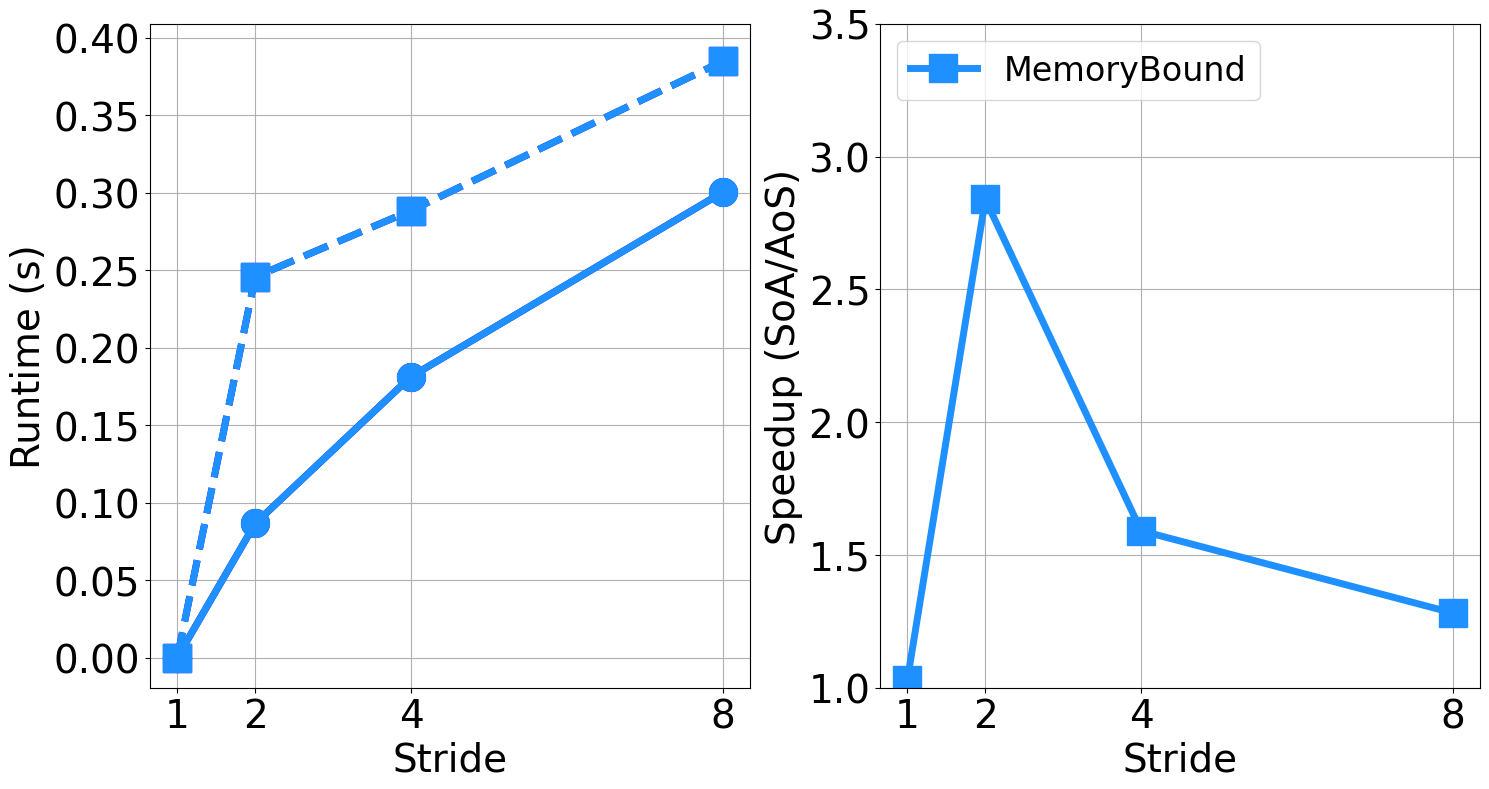

In [25]:
import itertools

selected_type = "double"
selected_vec = "vec"
selected_size = list(soa2aos_mean.values())[0]["size"].mean()
selected_reps = list(soa2aos_mean.values())[0]["repetitions"].mean()
selected_unit = list(soa2aos_mean.values())[0]["time_unit"].values[0]
selected_cmplr = "gcc"
selected_container = "std::vector"


fig = plt.figure(figsize=(15, 8))

colors = [
    "b",
    "dodgerblue",
    # "green",
]

ax = plt.subplot(1, 2, 1)
avg = soa2aos_mean[f"{selected_cmplr}_{selected_vec}"].copy()
std = soa2aos_std[f"{selected_cmplr}_{selected_vec}"].copy()
stride_list = avg["stride"].unique()
stride_list = [1,2,4,8]
for oi, selected_op in enumerate(avg["operation"].unique()):
    selected_op = "MemoryBound"
    for li, selected_lo in enumerate(avg["layout"].unique()):
        avg_filtered = avg[
            (avg["type"] == selected_type)
            & (avg["container"] == selected_container)
            & (avg["layout"] == selected_lo)
            & (avg["operation"] == selected_op)
            # & (avg["stride"] != 8)
        ]
        std_filtered = std[
            (std["type"] == selected_type)
            & (std["container"] == selected_container)
            & (std["layout"] == selected_lo)
            & (std["operation"] == selected_op)
            # & (avg["stride"] != 8)
        ]

        x = stride_list
        plt.errorbar(
            x,
            avg_filtered["real_time"][:-1]/1e3,
            yerr=std_filtered["real_time"][:-1]/1e3,
            label=f"{selected_lo} {selected_op}",
            marker=markers[li],
            color=colors[oi],
            ls=linestyles[li],
            lw=5,
            ms=20,
        )
plt.xticks(x, fontsize=28)
plt.xlabel("Stride", fontsize=28)
plt.yticks(fontsize=28)
plt.grid()

plt.ylabel(f"Runtime (s)", fontsize=28)
# plt.ylabel(f"Runtime ({selected_unit})", fontsize=28)
# plt.ylim([0, 5])
plt.xticks(x)
# plt.legend(fontsize=28, loc="upper left")

ax = plt.subplot(1, 2, 2)
# for oi, selected_op in enumerate(avg["operation"].unique()):
selected_op = "MemoryBound"
avg_filtered = avg[
    (avg["type"] == selected_type)
    & (avg["container"] == selected_container)
    & (avg["operation"] == selected_op)
]
std_filtered = std[
    (std["type"] == selected_type)
    & (std["container"] == selected_container)
    & (std["operation"] == selected_op)
]
avg_aos = avg_filtered[avg_filtered["layout"] == "AoS"]
std_aos = std_filtered[std_filtered["layout"] == "AoS"]
avg_soa = avg_filtered[avg_filtered["layout"] == "SoA"]
std_soa = std_filtered[std_filtered["layout"] == "SoA"]

plt.errorbar(
    x,
    # avg_aos["real_time"].values / avg_soa["real_time"],
    avg_soa["real_time"][:-1].values / avg_aos["real_time"][:-1],
    # yerr=std_aos,
    label=f"{selected_op}",
    marker=markers[oi],
    color=colors[oi],
    lw=5,
    ms=20,
)
plt.ylim([1,3.5])
plt.xticks(x, fontsize=28)
plt.yticks(fontsize=28)
plt.xlabel("Stride", fontsize=28)
plt.ylabel(f"Speedup (SoA/AoS)", fontsize=28)
plt.grid()
plt.legend(fontsize=24, loc="upper left")

plt.tight_layout()
plt.savefig(
    f"images/soa2aos_vec_{selected_type}_{commit}.pdf",
    format="pdf",
    bbox_inches="tight",
)
plt.show()

# False Sharing

In [17]:
def get_layout_fs(s):
    if "AoSoA" in s:
        return "AoSoA"
    elif "SoA" in s:
        return  "SoA"
    else:
        return "AoS"


def get_operation_fs(row):
    lo_offset = row["layout"]
    end = row["name"].find("<") - len(lo_offset)
    start = row["name"].find("BM_") + 3
    return row["name"][start:end]

In [18]:
def read_file_fs(commit):
    with open(f"false_sharing/results_{commit}", "r") as read_file:
        data = json.load(read_file)
        df = pd.DataFrame.from_dict(data["benchmarks"]).astype({"real_time": float})
        df["container"] = df["name"].apply(get_container)
        df["layout"] = df["name"].apply(get_layout_fs)
        df["operation"] = df.apply(get_operation_fs, axis=1)
        return df


commit_fs = "75ec7a"
results_fs = read_file_fs(commit_fs)
results_fs

,name,family_index,per_family_instance_index,run_name,run_type,repetitions,repetition_index,threads,iterations,real_time,...,time_unit,L1-dcache-load-misses,L1-dcache-loads,num_threads,size,aggregate_name,aggregate_unit,container,layout,operation
0,"BM_FalseSharing1AoS<AoS8Vec<double, container_...",0,0,"BM_FalseSharing1AoS<AoS8Vec<double, container_...",iteration,10,0.0,1,1,637.900810,...,ms,7.877870e+05,1.416736e+07,1.0,128.0,NaN,NaN,std::vector,AoS,FalseSharing1
1,"BM_FalseSharing1AoS<AoS8Vec<double, container_...",0,0,"BM_FalseSharing1AoS<AoS8Vec<double, container_...",iteration,10,1.0,1,1,595.349741,...,ms,6.652430e+05,1.416060e+07,1.0,128.0,NaN,NaN,std::vector,AoS,FalseSharing1
2,"BM_FalseSharing1AoS<AoS8Vec<double, container_...",0,0,"BM_FalseSharing1AoS<AoS8Vec<double, container_...",iteration,10,2.0,1,1,588.837714,...,ms,6.505280e+05,1.416040e+07,1.0,128.0,NaN,NaN,std::vector,AoS,FalseSharing1
3,"BM_FalseSharing1AoS<AoS8Vec<double, container_...",0,0,"BM_FalseSharing1AoS<AoS8Vec<double, container_...",iteration,10,3.0,1,1,925.953513,...,ms,7.582000e+05,1.416065e+07,1.0,128.0,NaN,NaN,std::vector,AoS,FalseSharing1
4,"BM_FalseSharing1AoS<AoS8Vec<double, container_...",0,0,"BM_FalseSharing1AoS<AoS8Vec<double, container_...",iteration,10,4.0,1,1,872.896889,...,ms,7.559170e+05,1.416020e+07,1.0,128.0,NaN,NaN,std::vector,AoS,FalseSharing1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,"BM_FalseSharing8SoA<SoA8Vec<double, container_...",7,0,"BM_FalseSharing8SoA<SoA8Vec<double, container_...",iteration,10,9.0,1,1,827.846360,...,ms,2.376696e+08,1.132825e+08,8.0,128.0,NaN,NaN,std::vector,SoA,FalseSharing8
108,"BM_FalseSharing8SoA<SoA8Vec<double, container_...",7,0,"BM_FalseSharing8SoA<SoA8Vec<double, container_...",aggregate,10,NaN,1,10,835.059045,...,ms,2.407650e+08,1.132831e+08,8.0,128.0,mean,time,std::vector,SoA,FalseSharing8
109,"BM_FalseSharing8SoA<SoA8Vec<double, container_...",7,0,"BM_FalseSharing8SoA<SoA8Vec<double, container_...",aggregate,10,NaN,1,10,841.911492,...,ms,2.461987e+08,1.132834e+08,8.0,128.0,median,time,std::vector,SoA,FalseSharing8
110,"BM_FalseSharing8SoA<SoA8Vec<double, container_...",7,0,"BM_FalseSharing8SoA<SoA8Vec<double, container_...",aggregate,10,NaN,1,10,51.262191,...,ms,4.501483e+07,5.729980e+02,0.0,0.0,stddev,time,std::vector,SoA,FalseSharing8


In [19]:
fs_mean = results_fs[results_fs["aggregate_name"] == "mean"]
fs_std = results_fs[results_fs["aggregate_name"] == "stddev"]
fs_mean

,name,family_index,per_family_instance_index,run_name,run_type,repetitions,repetition_index,threads,iterations,real_time,...,time_unit,L1-dcache-load-misses,L1-dcache-loads,num_threads,size,aggregate_name,aggregate_unit,container,layout,operation
10,"BM_FalseSharing1AoS<AoS8Vec<double, container_...",0,0,"BM_FalseSharing1AoS<AoS8Vec<double, container_...",aggregate,10,NaN,1,10,682.162348,...,ms,7.254730e+05,14161068.8,1.0,128.0,mean,time,std::vector,AoS,FalseSharing1
24,"BM_FalseSharing1SoA<SoA8Vec<double, container_...",1,0,"BM_FalseSharing1SoA<SoA8Vec<double, container_...",aggregate,10,NaN,1,10,2109.650120,...,ms,7.251219e+05,12743507.6,1.0,128.0,mean,time,std::vector,SoA,FalseSharing1
38,"BM_FalseSharing2AoS<AoS8Vec<double, container_...",2,0,"BM_FalseSharing2AoS<AoS8Vec<double, container_...",aggregate,10,NaN,1,10,7393.229414,...,ms,2.359182e+09,28318722.0,2.0,128.0,mean,time,std::vector,AoS,FalseSharing2
52,"BM_FalseSharing2SoA<SoA8Vec<double, container_...",3,0,"BM_FalseSharing2SoA<SoA8Vec<double, container_...",aggregate,10,NaN,1,10,1253.874776,...,ms,2.853980e+07,28320599.4,2.0,128.0,mean,time,std::vector,SoA,FalseSharing2
66,"BM_FalseSharing4AoS<AoS8Vec<double, container_...",4,0,"BM_FalseSharing4AoS<AoS8Vec<double, container_...",aggregate,10,NaN,1,10,14182.628651,...,ms,4.583015e+09,56645459.1,4.0,128.0,mean,time,std::vector,AoS,FalseSharing4
80,"BM_FalseSharing4SoA<SoA8Vec<double, container_...",5,0,"BM_FalseSharing4SoA<SoA8Vec<double, container_...",aggregate,10,NaN,1,10,1068.993773,...,ms,8.727874e+07,56641340.0,4.0,128.0,mean,time,std::vector,SoA,FalseSharing4
94,"BM_FalseSharing8AoS<AoS8Vec<double, container_...",6,0,"BM_FalseSharing8AoS<AoS8Vec<double, container_...",aggregate,10,NaN,1,10,24197.841374,...,ms,9.030976e+09,113299975.6,8.0,128.0,mean,time,std::vector,AoS,FalseSharing8
108,"BM_FalseSharing8SoA<SoA8Vec<double, container_...",7,0,"BM_FalseSharing8SoA<SoA8Vec<double, container_...",aggregate,10,NaN,1,10,835.059045,...,ms,2.407650e+08,113283149.6,8.0,128.0,mean,time,std::vector,SoA,FalseSharing8


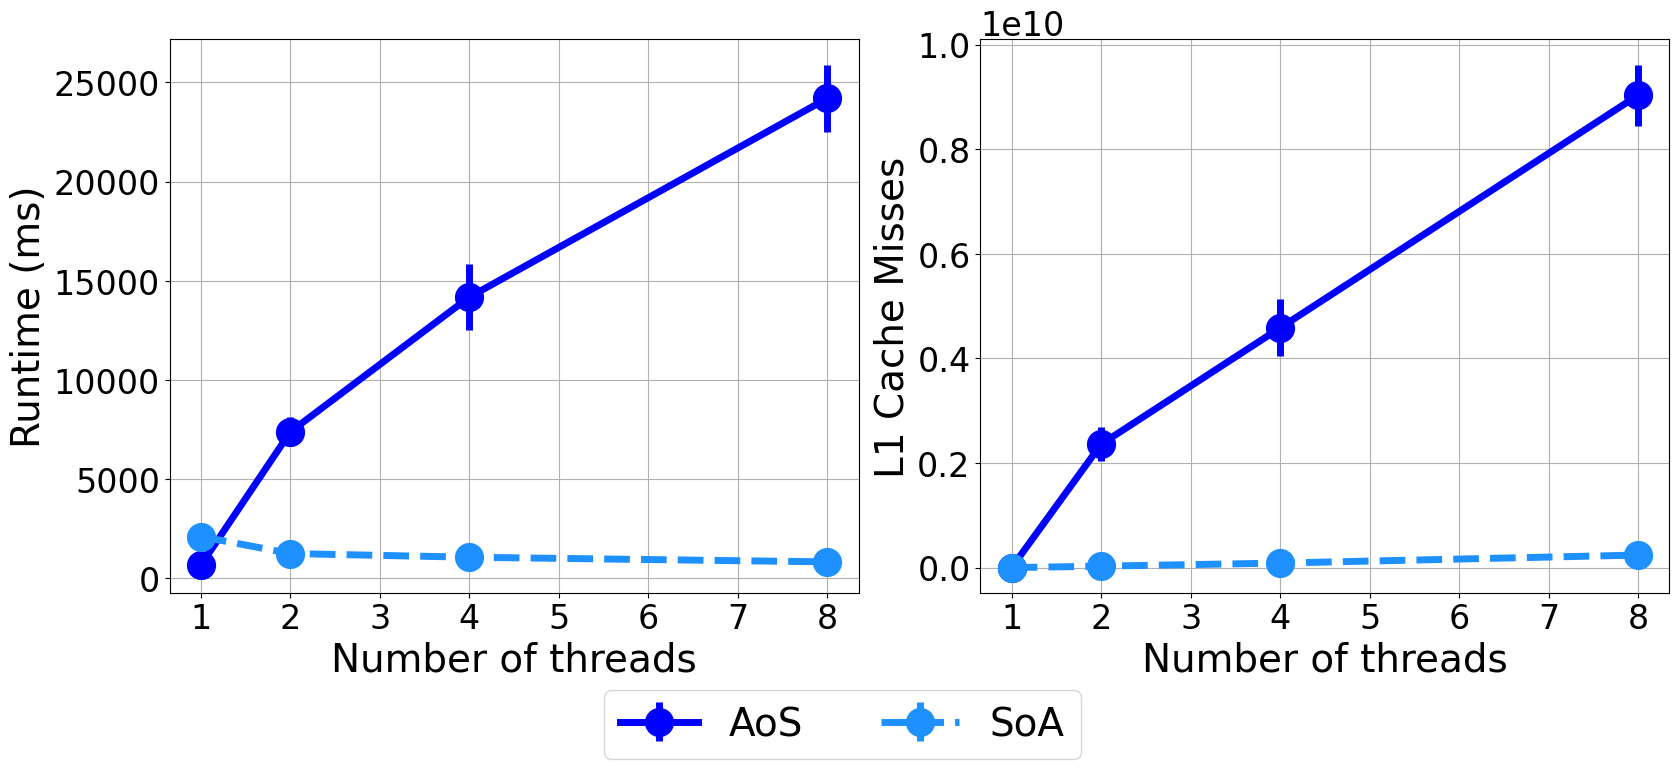

In [20]:
plt.figure(figsize=(25, 7))

selected_container = "std::vector"
selected_unit = fs_mean["time_unit"].values[0]
colors = ["b", "dodgerblue"]

for yi, yaxis in enumerate(["real_time", "L1-dcache-load-misses"]):
    ax = plt.subplot(1, 3, yi + 1)
    avg = fs_mean.copy()
    std = fs_std.copy()
    for li, selected_lo in enumerate(avg["layout"].unique()):
        avg_filtered = avg[
            (avg["container"] == selected_container)
            & (avg["layout"] == selected_lo)
        ]
        std_filtered = std[
            (std["container"] == selected_container)
            & (std["layout"] == selected_lo)
        ]

        x = avg_filtered["num_threads"]
        plt.errorbar(
            x,
            avg_filtered[yaxis],
            yerr=std_filtered[yaxis],
            label=f"{selected_lo}",
            marker=markers[0],
            color=colors[li],
            ls=linestyles[li],
            lw=5,
            ms=20,
        )

    plt.grid("on")
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    plt.xlabel("Number of threads", fontsize=28)
    # plt.ylabel(f"Runtime ({selected_unit})", fontsize=28)
    if yi == 0: 
        plt.ylabel(f"Runtime ({selected_unit})", fontsize=28)
    else:
       plt.ylabel(f"L1 Cache Misses", fontsize=28)
    t = ax.yaxis.get_offset_text()
    t.set_size(24)

    plt.tight_layout()

plt.legend(loc="upper center", fontsize=28, bbox_to_anchor=(-0.2, -0.14), ncol=4)
plt.savefig(
    f"images/falsesharing_{selected_type}_{commit}.pdf",
    format="pdf",
    bbox_inches="tight",
)
plt.show()

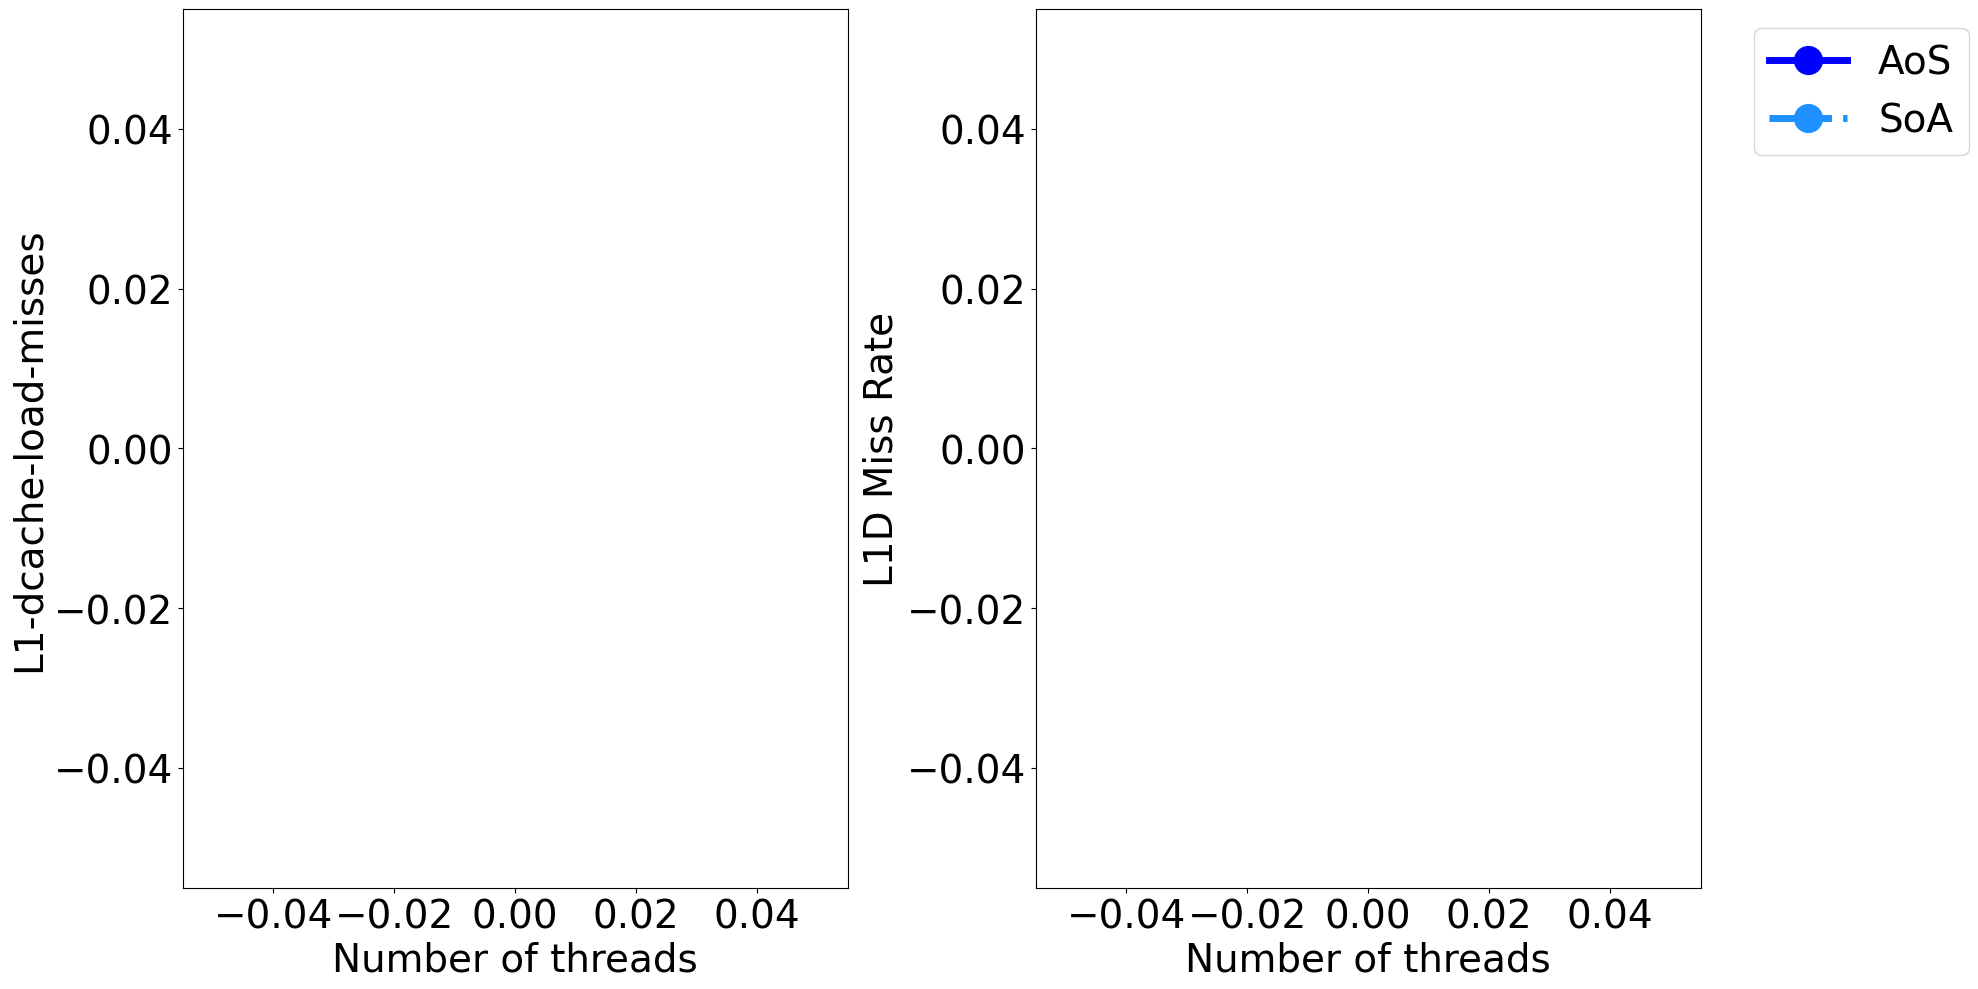

In [21]:
plt.figure(figsize=(20, 10))

selected_container = "std::vector"
selected_unit = fs_mean["time_unit"].values[0]

avg = fs_mean.copy()
std = fs_std.copy()

plt.subplot(1, 2, 1)
selected_op = "Flat"
# for oi, selected_op in enumerate(avg["operation"].unique()):
for li, selected_lo in enumerate(avg["layout"].unique()):
    avg_filtered = avg[
        (avg["container"] == selected_container)
        & (avg["operation"] == selected_op)
        & (avg["layout"] == selected_lo)
    ]
    std_filtered = std[
        (std["container"] == selected_container)
        & (std["operation"] == selected_op)
        & (std["layout"] == selected_lo)
    ]

    x = avg_filtered["num_threads"]
    plt.errorbar(
        x,
        avg_filtered["real_time"],
        yerr=std_filtered["real_time"],
        label=f"{selected_lo}",
        marker=markers[0],
        color=colors[li],
        ls=linestyles[li],
        lw=5,
        ms=20,
    )

plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xlabel("Number of threads", fontsize=28)
plt.ylabel(f"Runtime ({selected_unit})", fontsize=28)
plt.ylabel(f"{yaxis}", fontsize=28)

plt.tight_layout()

################
plt.subplot(1, 2, 2)
# for oi, selected_op in enumerate(avg["operation"].unique()):
for li, selected_lo in enumerate(avg["layout"].unique()):
    avg_filtered = avg[
        (avg["container"] == selected_container)
        & (avg["operation"] == selected_op)
        & (avg["layout"] == selected_lo)
    ]
    std_filtered = std[
        (std["container"] == selected_container)
        & (std["operation"] == selected_op)
        & (std["layout"] == selected_lo)
    ]

    x = avg_filtered["num_threads"]
    plt.errorbar(
        x,
        avg_filtered["L1-dcache-load-misses"] / avg_filtered["L1-dcache-loads"],
        # yerr=std_filtered["L1-dcache-load-misses"]/std_filtered["L1-dcache-loads"],
        label=f"{selected_lo}",
        marker=markers[0],
        color=colors[li],
        ls=linestyles[li],
        lw=5,
        ms=20,
    )

plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xlabel("Number of threads", fontsize=28)
plt.ylabel(f"L1D Miss Rate", fontsize=28)

plt.legend(loc="upper left", fontsize=28, bbox_to_anchor=(1.05, 1))
plt.tight_layout()

plt.show()